In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
import design_parameters as dp

In [3]:
print(dp.coord_thickness, dp.n_layers)

2.0500000000000003 65


In [4]:
#return a pandas.DataFrame of the cell positions.
#check for the reasonable side lengths
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

def cell_positions(layer, poly,
                   R_readout=0.4, sidelength=1.889, debug=False, wall_thickness=dp.wall_thickness, 
                   wall_scint_gap=dp.wall_scint_gap, minCellAreaFraction=1/3,
                  augment_cells=False):
    if wall_thickness!=0:
        poly=poly.buffer(-wall_thickness/2)
    
    y0=sidelength/2+min(poly.exterior.xy[1])
    
    nrows = int((max(poly.exterior.xy[1])-min(poly.exterior.xy[1]))/(sidelength*np.sqrt(3)/2)+3)
    
    y0=(max(poly.exterior.xy[1])+min(poly.exterior.xy[1]))/2-sidelength*np.sqrt(3)/2*((nrows-1)//2)
    
    
    ncol= int((max(poly.exterior.xy[0])-min(poly.exterior.xy[0]))/(sidelength*3/2))+3
    x0=min(poly.exterior.xy[0])
    
    
    
    # x,y are the position of the SiPM and dimple center
    # xh and yh are the position of the center of the hexagon.  
    # These are the same for a regular hexagon or any cropped hexagon that doesn't have a shifted dimple
    d={a:[] for a in "x y xh yh row col boundsx boundsy area dimpleshift cropped augmented scint_boundsx scint_boundsy scint_area deadzone".split()}
    
    
    shiftX=[-sidelength, 0, sidelength][layer%3]
    shiftY=[0, 0, 0][layer%3]
    
    phi=np.linspace(-2*np.pi/3, np.pi, 6)
    for i in range(nrows):
        for j in range(-1, ncol):
            if (i +j) %2!=0:
                continue
            x=x0+j*sidelength*3/2+shiftX
            y=y0+sidelength*np.sqrt(3)/2*i+shiftY
            
            xh=x
            yh=x
            
            xc=x
            yc=y
            
            cellTooSmall=False
            point=Point(x,y)
            #check if the dimple fits inside the boundaries.
            if not point.buffer(R_readout).within(poly):
                hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
                overlap=poly.intersection(hexagon)
                if overlap.area==0:
                    continue
                
                # now see if shifting the dimple to the centroid will allow the dimple to fit
                # otherwise merge with neighbors
                centroid=overlap.centroid
                if not centroid.buffer(R_readout).within(poly):
                    cellTooSmall=True
                    
                # now see if the cell's area is more than a specified fraction of a 
                # standard hexagon's area.  otherwise merge with neighbors
                if overlap.area/hexagon.area <  minCellAreaFraction:
                    cellTooSmall=True
                    
                # if the cell fragment fails these criteria,
                # either merge it with one of its neighbors,
                # or flag the fragment as a deadzone
                if cellTooSmall and augment_cells:
                    continue
                elif cellTooSmall:
                    d['deadzone'].append(1)
                else:
                    d['deadzone'].append(0)
                xc,yc = centroid.xy[0],centroid.xy[1]
                
                if type(xc) != float:
                    xc=float(xc[0])
                if type(yc) != float:
                    yc=float(yc[0])
                
                d['dimpleshift'].append(1)
            else :
                d['dimpleshift'].append(0)
                d['deadzone'].append(0)
            #print(type(xc))
            d['x'].append(xc)
            d['y'].append(yc)
            
            d['xh'].append(x)
            d['yh'].append(y)
            
            d['row'].append(i)
            d['col'].append(j)
            
            
            hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
            if poly.contains(hexagon):
                cropped = 0
                d['boundsx'].append(hexagon.exterior.xy[0])
                d['boundsy'].append(hexagon.exterior.xy[1])
                d['area'].append(hexagon.area)
                #smaller hexagon for the scintillator cell.
                scint_sidelength=sidelength-(wall_thickness/2+wall_scint_gap)/(np.sqrt(3)/2)
                hexagon2=Polygon(zip(x+scint_sidelength*np.cos(phi),y+scint_sidelength*np.sin(phi)))
                d['scint_boundsx'].append(hexagon2.exterior.xy[0])
                d['scint_boundsy'].append(hexagon2.exterior.xy[1])
                d['scint_area'].append(hexagon2.area)
            elif not cellTooSmall :
                cropped = 1
                newpoly=poly.intersection(hexagon)
                #print(newpoly.exterior)
                d['boundsx'].append(newpoly.exterior.xy[0])
                d['boundsy'].append(newpoly.exterior.xy[1])
                d['area'].append(newpoly.area)
                scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                d['scint_boundsx'].append(scint.exterior.xy[0])
                d['scint_boundsy'].append(scint.exterior.xy[1])
                d['scint_area'].append(scint.area)
            
            else: # for entries where a cell is not placed
                cropped=1
                newpoly=poly.intersection(hexagon)
                if not isinstance(newpoly, Polygon): 
                    #only happens if cropping the cell splits it into multiple parts
                    #very rare, but don't want this to crash
                    d['boundsx'].append(newpoly.geoms[0].exterior.xy[0])
                    d['boundsy'].append(newpoly.geoms[0].exterior.xy[1])
                else :
                    d['boundsx'].append(newpoly.exterior.xy[0])
                    d['boundsy'].append(newpoly.exterior.xy[1])
                d['area'].append(newpoly.area)
                d['scint_boundsx'].append([])
                d['scint_boundsy'].append([])
                d['scint_area'].append(0)
                
                
            d['cropped'].append(cropped)
            d['augmented'].append(0) # no augmenting at this stage yet.  
    df=pd.DataFrame(d)
    
    
    # the cell augmentation feature merges small fragments of cells on the edge of the 
    # detector with their whole neighbors.  If we choose not to use this feature, then we can 
    if not augment_cells:
        if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={poly.area}, ratio= {sum(df.area)/poly.area}")
        return df
    
    #now extend any cells that need extending.  Need to find a better way to do this
    for i in range(len(df)):
        #check if the neighboring cell is a fragment (which is not in the dataframe)
        #.  If so, take a piece of it and add it to the current cell.  
        dc, dr = (1, 1,0, -1, -1,0), (-1, 1,2,1, -1, -2)
        
        for j in range(len(dc)):
            r=df.row[i]+dr[j]
            c=df.col[i]+dc[j]
            if not len(df.query(f'row== {r} and col=={c}')):
                cell=Polygon(zip(df.boundsx[i], df.boundsy[i]))
                #find center of the fragmented 
                x=x0+(df.col[i]+dc[j])*sidelength*3/2+shiftX
                y=y0+sidelength*np.sqrt(3)/2*(df.row[i]+dr[j])+shiftY
                
                corner1 = (x+df.xh[i])/2+(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2-(df.xh[i]-x)/np.sqrt(3)/2
                corner2 = (x+df.xh[i])/2-(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2+(df.xh[i]-x)/np.sqrt(3)/2
                
                
                merge=Polygon([(x,y), corner1, (df.xh[i], df.yh[i]),corner2])
                
                newpoly=unary_union([cell,merge])
                newpoly=poly.intersection(newpoly).simplify(.0001)
                #print(newpoly)
                if not type(newpoly)== Polygon:
                    if debug: print("warning disjointed polygon!", type(newpoly), j)
                    continue
                df.loc[i,"boundsx"][:], df.loc[i,"boundsy"][:]= newpoly.exterior.xy
                df.loc[i,"area"]=newpoly.area
                
                scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                df.loc[i,'scint_boundsx'][:],df.loc[i,'scint_boundsy'][:]=scint.exterior.xy
                df.loc[i,'scint_area']=scint.area
                
                #if two consecutive neighbors are fragments, merge a larger fraction of both of them into this one
                for dj in 1,:
                    r2=df.row[i]+dr[(j+dj)%6]
                    c2=df.col[i]+dc[(j+dj)%6]
                    if not len(df.query(f'row== {r2} and col=={c2}')):
                        x2=x0+c2*sidelength*3/2+shiftX
                        y2=y0+sidelength*np.sqrt(3)/2*r2+shiftY
                        
                        corner3 = 2*(x+x2)/3-df.xh[i]/3,2*(y+y2)/3-df.yh[i]/3
                        
                        
                        
                        merge=Polygon([(x,y), corner3, (x2,y2), (df.xh[i], df.yh[i])])
                        #print(merge.area)
                        newpoly=unary_union([newpoly,merge])
                        newpoly=poly.intersection(newpoly)
                        #print(newpoly)
                        if not type(newpoly)== Polygon:
                            if debug: print("warning disjointed polygon!","XXXX")
                            continue
                        df.loc[i,"boundsx"][:], df.loc[i,"boundsy"][:]= newpoly.exterior.xy
                        df.loc[i,"area"]=newpoly.area
                        
                        scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                        df.loc[i,'scint_boundsx'][:],df.loc[i,'scint_boundsy'][:]=scint.exterior.xy
                        df.loc[i,'scint_area']=scint.area
                        
                tol=1e-7
                if abs(newpoly.area-cell.area)/cell.area>tol:
                    df.loc[i,"augmented"]=1
                
    if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={poly.area}, ratio= {sum(df.area)/poly.area}")
    return df
            

In [5]:

def draw_layer(layer, R_readout=0.4, sidelength=1.889, fillDimple=True, color=None, shade_deadzone=True):
    phi = np.linspace(-np.pi, np.pi, 7)
    dx=sidelength*np.cos(phi)
    dy=sidelength*np.sin(phi)
    if color == None:
        color='krb'[layer%3] 
    
    for side in "LR":
        boundaries=dp.layer_boundaries(layer, side)
        
        plt.plot(*boundaries.exterior.xy, linestyle='-', color=color)
        df = cell_positions(layer,boundaries, R_readout, sidelength)
        for i in range(len(df)):
            plt.plot(df.boundsx[i], df.boundsy[i], color=color)
            if not df.deadzone[i]:
                plt.gca().add_patch(mpl.patches.Circle((df.x[i], df.y[i]), R_readout, color=color,
                                                          linestyle='' if fillDimple else '-',
                                                        fill=fillDimple))
            elif shade_deadzone:
                plt.gca().add_patch(mpl.patches.Polygon(list(zip(df.boundsx[i], df.boundsy[i])), color=color,
                                                       alpha=0.3))
            
            #plt.plot(df.x[i]+dx, df.y[i]+dy, color=color)
    

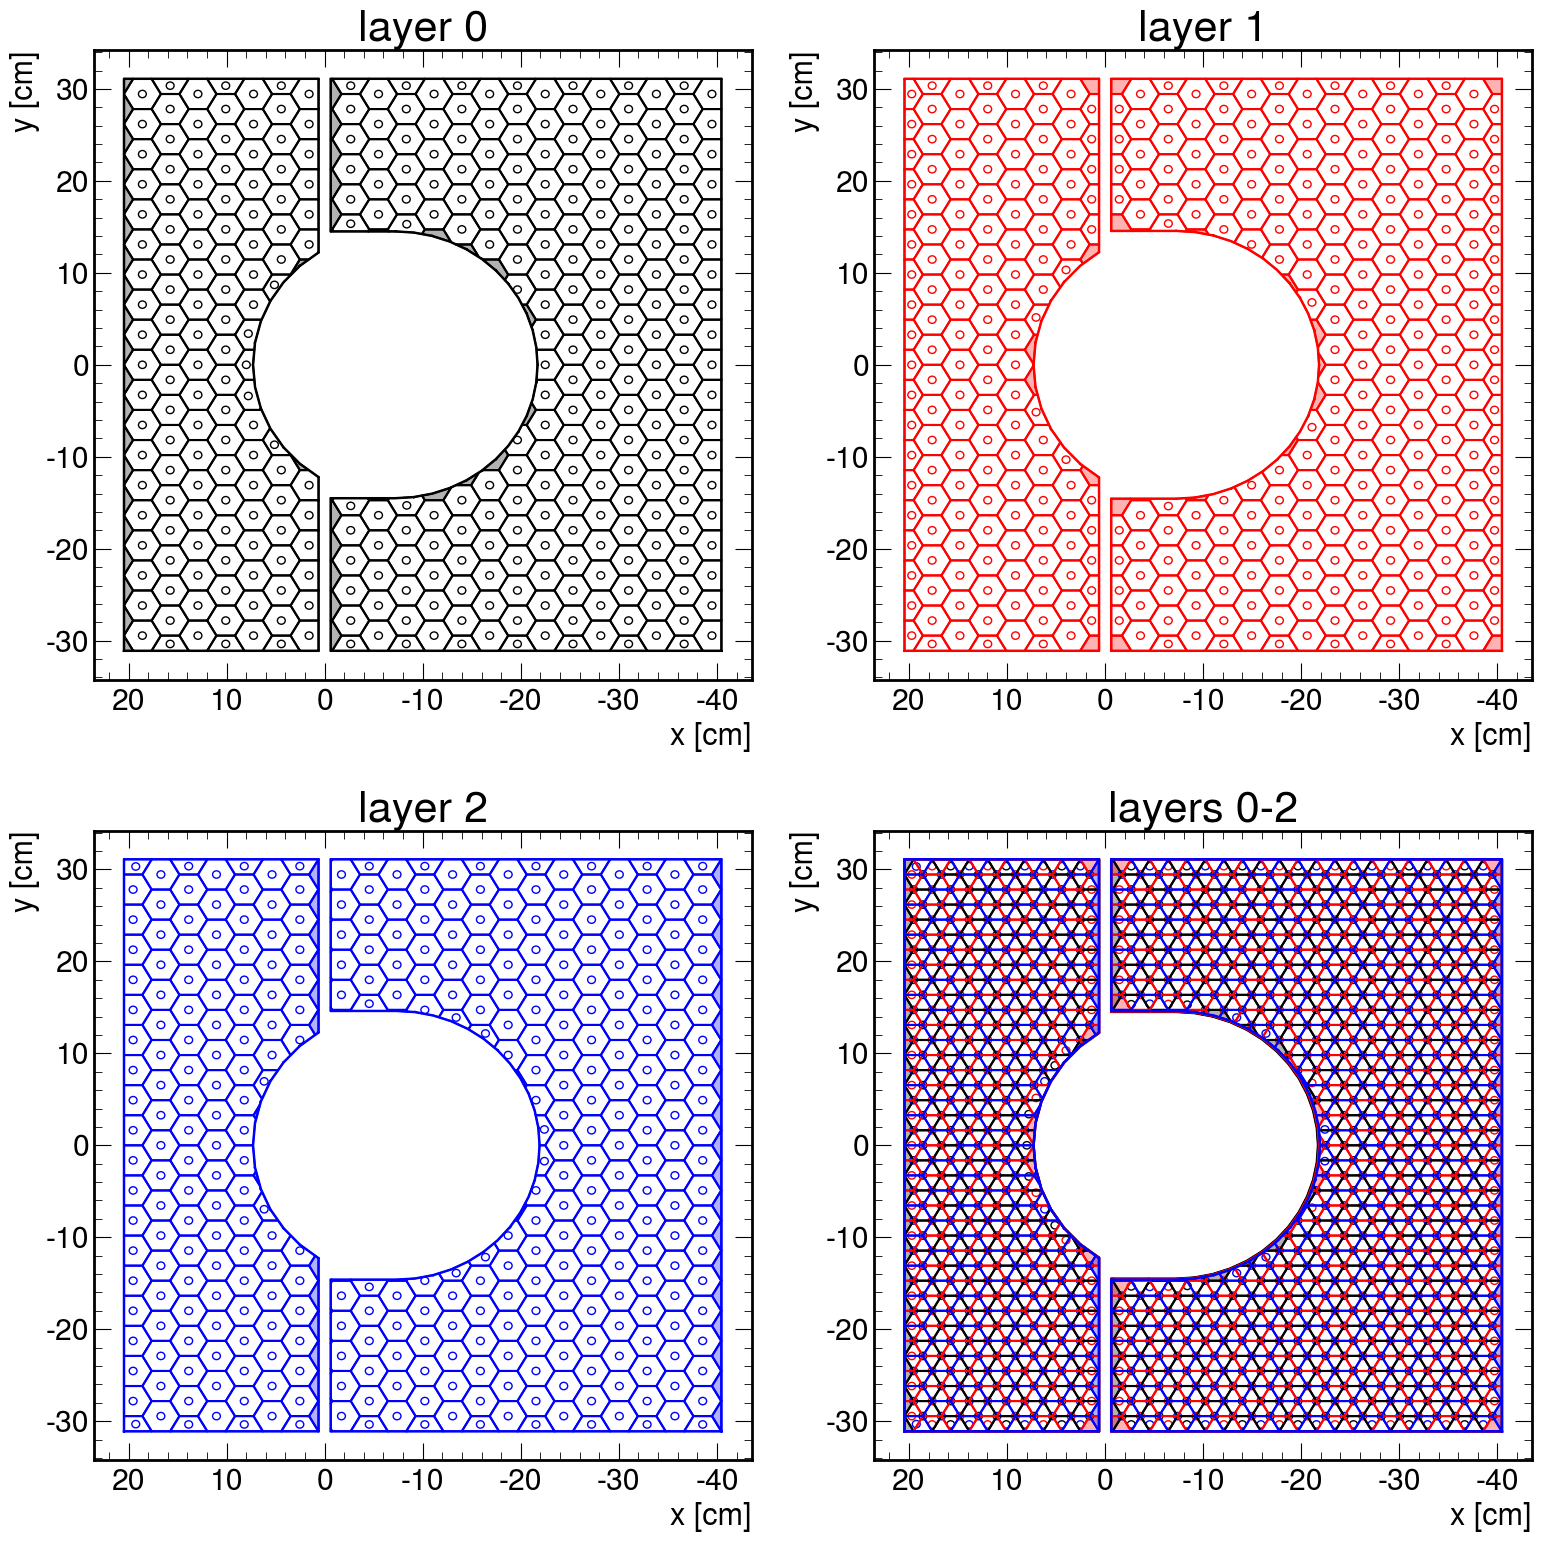

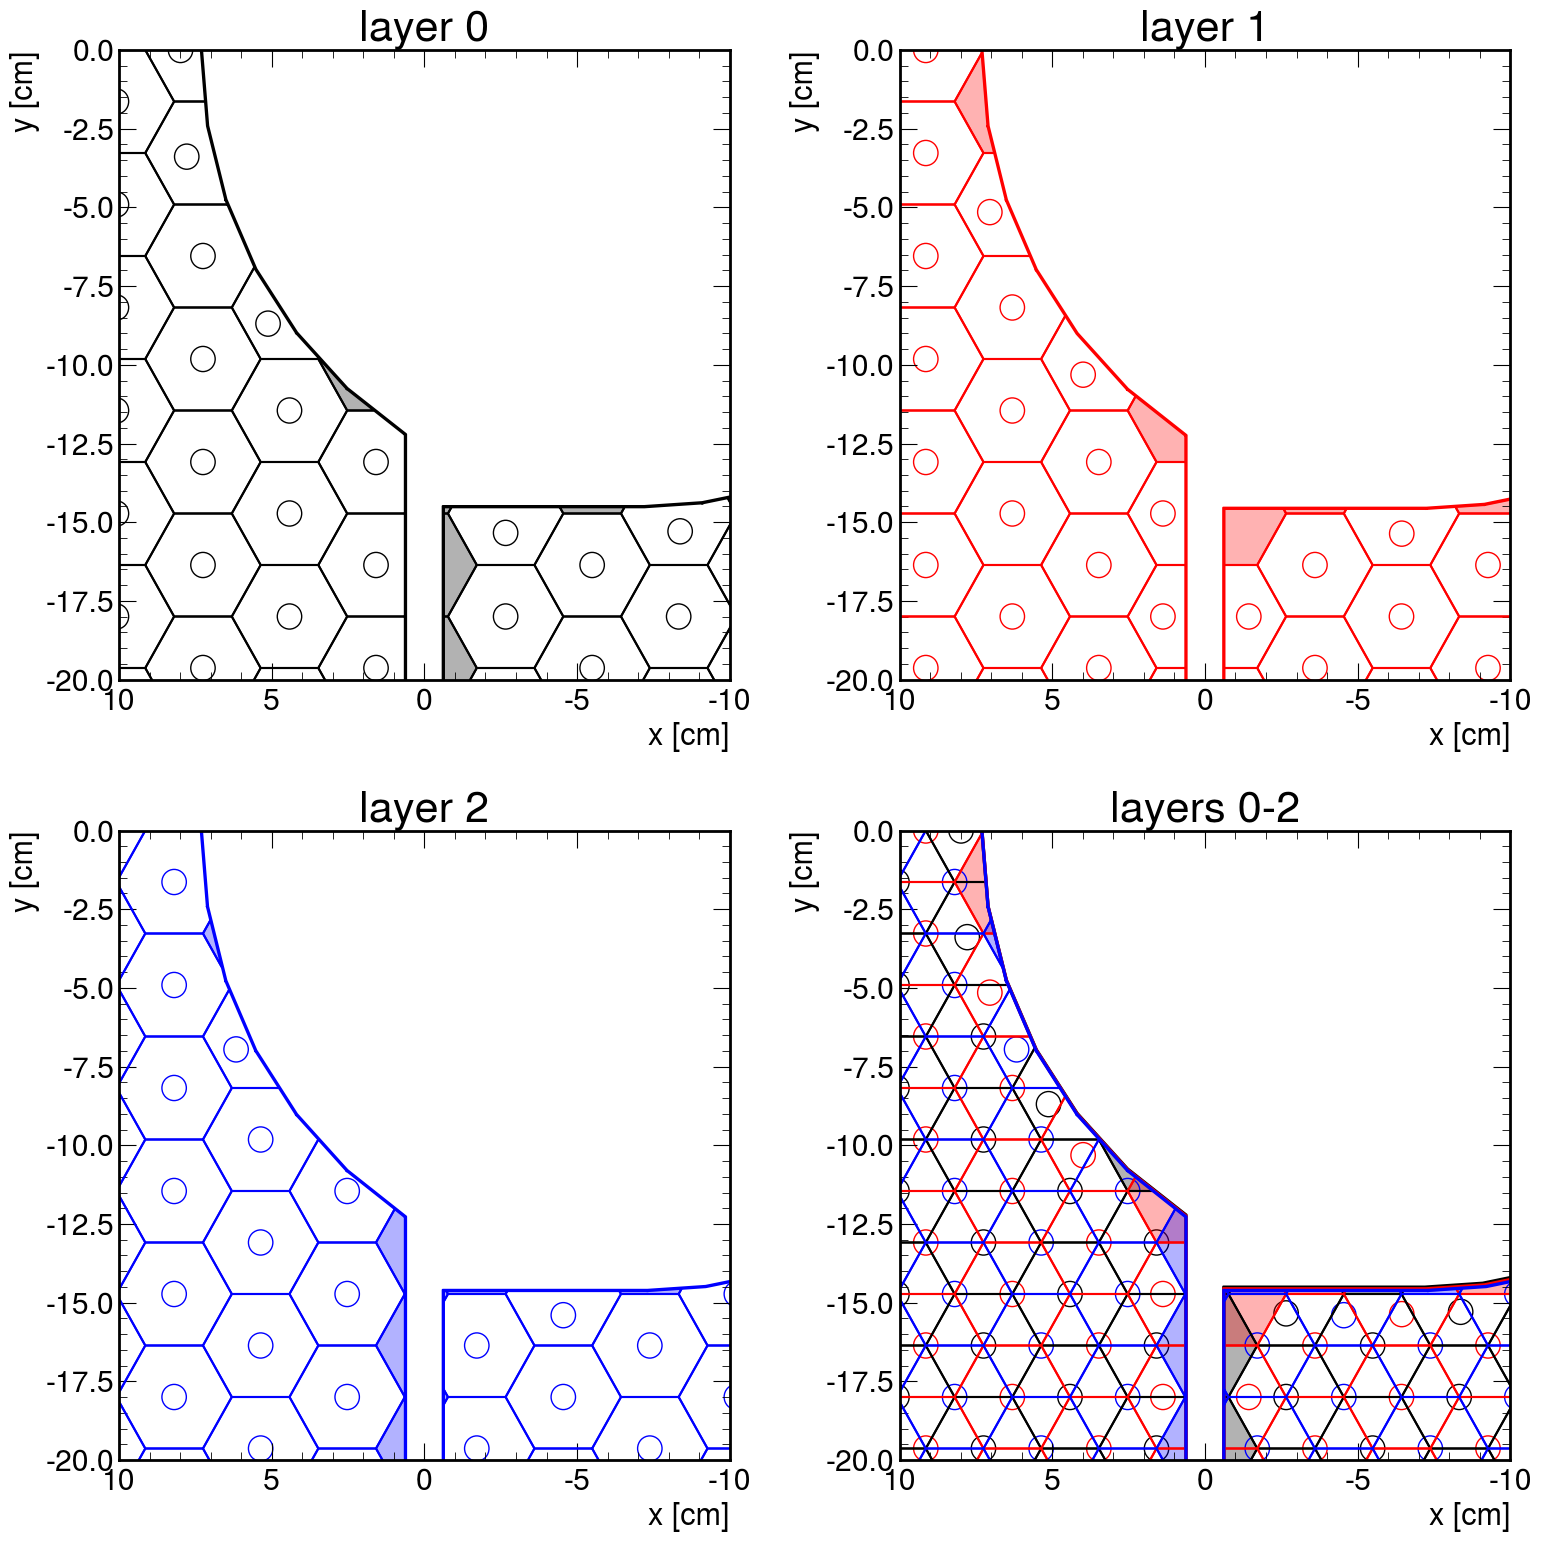

In [6]:

sidelength=dp.sidelengths[0]


for zoom in False, True:
    arg=dict(fillDimple=False, sidelength=sidelength)
    fig,axs=plt.subplots(2,2, figsize=(16,16))
    for i in range(3):

        plt.sca(axs[i//2][i%2])
        plt.title(f"layer {i}")
        draw_layer(i, **arg)
        plt.gca().invert_xaxis()
        plt.sca(axs[1][1])
        plt.title(f"layers 0-2")
        draw_layer(i, **arg)
    axs[1][1].invert_xaxis()
    for row in axs:
        for ax in row:
            ax.set_xlabel("x [cm]", fontsize=22)
            ax.set_ylabel("y [cm]", fontsize=22)
            if zoom:
                ax.set_xlim(-10, 10)
                ax.set_ylim(-20, 0)
                ax.invert_xaxis()
    plt.tight_layout()
    plt.savefig(f"Layers_0-2{'_zoom' if zoom else ''}.pdf")
    plt.show()

L:
   dz layer 0:,28.50
   dz layer 1:,12.45
   dz layer 2:,18.78
   dz layers 0,1 overlap:,0.37809930995307467
   dz layers 0,2 overlap:,0.0
   dz layers 1,2 overlap:,2.9575899548897473
   dz layers 0,1,2 overlap:,0.0
R:
   dz layer 0:,33.07
   dz layer 1:,23.94
   dz layer 2:,31.24
   dz layers 0,1 overlap:,5.036192396596878
   dz layers 0,2 overlap:,0.39297357240842284
   dz layers 1,2 overlap:,2.0668360588973456
   dz layers 0,1,2 overlap:,0.08797894534224988


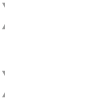

In [7]:
#check how much space is shared cell-too-small deadzone between all three layers
for side in "LR":
    dzs=[]
    for layer in range(3):
        df=cell_positions(layer,dp.layer_boundaries(layer, side))
        for i in range(len(df)):
            dzs.append(None)
            if df.deadzone[i]:
                p=Polygon(zip(df.boundsx[i], df.boundsy[i]))
                if dzs[layer] is None:
                    dzs[layer] = p
                else :
                    dzs[layer] = p | dzs[layer]
    print(f"{side}:")
    for i in range(3):
        print(f"   dz layer {i}:,{dzs[i].area:.2f}")
    for i in range(3):
        for j in range(3):
            if j >i:
                print(f"   dz layers {i},{j} overlap:,{(dzs[i]& dzs[j]).area}")
    print(f"   dz layers 0,1,2 overlap:,{(dzs[0]& dzs[1] & dzs[2]).area}")

    
(dzs[0]& dzs[1] & dzs[2])                                      
        

In [8]:
def print_summary_stats(df, boundary):
    hexagons=df.query("augmented==0 and cropped==0")
    tot_area=boundary.area
    hex_area=sum(hexagons.area)
    
    n_tot = len(df)
    n_hex = len(hexagons)
    print(f"total area: {tot_area:.1f} cm^2")
    print(f"area covered by regular hexagons: {hex_area:.1f} cm^2")
    print(f"(regular hexagon area)/(total area): {100*hex_area/tot_area:.1f}%")
    print(f"total cells: {n_tot}")
    print(f"# of regular hexagon cells: {n_hex}")
    print(f"(regular hexagon cells)/(total cells): {100*n_hex/n_tot:.1f}%")
    
    scint_area=sum(df.scint_area)
    scint_hex_area=sum(df.query("augmented==0 and cropped==0").scint_area)
    
    print(f"scintillator area: {scint_area} cm^2")
    print(f"dead area: {tot_area-scint_area:.1f} cm^2  ({100*(tot_area-scint_area)/scint_area:.1f}%)")
    
    
    print(f"area covered by regular hexagon scintillators: {scint_hex_area:.1f} cm^2 ({100*scint_hex_area/tot_area:.1f}% of total)")
    
    

In [9]:
#now tabulate all layers, and also create a dataframe that contains the summary variables
all_layers ={}
beampipe=dp.beampipe0

sidelengths=dp.sidelengths
absorber_material=dp.absorber_material
first_in_gang=[1]*dp.n_layers#+[1,1,1,0,0,0,0,0,0,0,0,0]+ [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]*2
#first_in_gang=[1]*24+[1,1,1,0,0,0,0,0,0]*4

#first_in_gang=[1]*24+[1,1,1,0,0,0]*6
columns=[]
columns+="layer side holeX holeR deadzone_frac channels reg_hexes sidelength absorber_material first_in_gang".split()
columns+="tot_area scint_area deadzone_area".split()
d={a:[] for a in columns}
for layer in range(len(sidelengths)):
    holex=beampipe.holeX(layer)
    holer=beampipe.holeR(layer)
    for side in "LR":
        sidelength=sidelengths[layer]
        bounds=dp.layer_boundaries(layer, side)
        #print(bounds.exterior.xy)
        #print(min(bounds.exterior.xy[0]))
        df_layer_side=cell_positions(layer, bounds,
                   R_readout=0.4, sidelength=sidelength,minCellAreaFraction=1/3, augment_cells=False)
        
        all_layers[(layer, side)]=df_layer_side
        d['layer'].append(layer)
        d['side'].append(side)
        d['holeX'].append(holex)
        d['holeR'].append(holer)
        tot_area=bounds.area
        d['tot_area'].append(tot_area)
        scint_area=sum(df_layer_side.scint_area)
        d['scint_area'].append(scint_area)
        deadzone_area=tot_area-scint_area
        d['deadzone_area'].append(deadzone_area)
        
        deadzone_frac = deadzone_area/tot_area
        d['deadzone_frac'].append(deadzone_frac)
        
        d['channels'].append(len(df_layer_side.query("deadzone==0")))
        d['reg_hexes'].append(len(df_layer_side.query('augmented==0 and cropped==0 and deadzone==0')))
        d['sidelength'].append(sidelength)
        d['absorber_material'].append(absorber_material[layer])
        d['first_in_gang'].append(first_in_gang[layer])
        
summary=pd.DataFrame(d)

In [10]:
#create a pickle file with the layouts of all of the layers
import pickle
with open("all_layers.pkl",'wb') as f:
    pickle.dump(all_layers,f)
with open("summary.pkl", 'wb') as f:
    pickle.dump(summary,f)


In [11]:
print("layer,pcb area (cm2),scint area (cm2),SiPMs")
for layer in range(dp.n_layers):
    #sub dataframe for this layer.  2 entries (top, bottom)
    df=summary.query(f"layer=={layer}")
    print(f"{layer},{sum(df.tot_area):.1f},{sum(df.scint_area):.1f},{sum(df.channels)}")

df=summary
print(f"total,{sum(df.tot_area):.1f},{sum(df.scint_area):.1f},{sum(df.channels)}")

layer,pcb area (cm2),scint area (cm2),SiPMs
0,3085.4,2824.5,345
1,3080.6,2837.3,368
2,3075.7,2824.9,349
3,3070.9,2816.4,345
4,3066.0,2828.9,368
5,3061.1,2797.1,343
6,3056.2,2806.6,345
7,3051.3,2807.7,133
8,3046.3,2721.4,121
9,3041.4,2808.8,134
10,3036.4,2789.6,132
11,3031.4,2709.6,121
12,3026.3,2802.0,134
13,3021.3,2778.9,132
14,3016.2,2696.8,121
15,3011.2,2793.7,134
16,3006.1,2767.3,132
17,3000.9,2683.8,121
18,2995.8,2768.9,132
19,2990.6,2740.8,130
20,2985.5,2655.5,119
21,2980.3,2760.5,132
22,2975.1,2731.5,130
23,2969.8,2644.5,119
24,2964.6,2751.0,132
25,2959.3,2721.4,130
26,2954.0,2620.2,117
27,2948.7,2740.5,132
28,2943.4,2710.4,130
29,2938.0,2599.2,115
30,2932.7,2729.4,132
31,2927.3,2698.6,130
32,2921.9,2593.3,115
33,2916.5,2717.5,132
34,2911.0,2685.6,130
35,2905.6,2585.6,115
36,2900.1,2704.0,132
37,2894.6,2672.0,130
38,2889.1,2577.0,115
39,2883.5,2689.0,132
40,2878.0,2642.5,128
41,2872.4,2567.8,115
42,2866.8,2666.7,131
43,2861.2,2628.9,128
44,2855.6,2555.9,115
45,2849.9,2651.9,131


In [12]:
len(summary.query("absorber_material=='Fe'"))/2

55.0

In [13]:
abs_thick=dp.components['absorber'].thickness

nlambda_per_layer = {"W": 0.16899*abs_thick/1.61, "Fe":0.10697*abs_thick/1.61}
nrad_per_layer = {"W": abs_thick/0.3504,  "Fe": abs_thick/1.757}

print(f"side length (cm)  area (cm^2)   layers  n_lambda n_rad cells\thexes channels")
tot_chan=0
nlambda_tot=0
nrad_tot=0
tot_chan_right=0
tot_cells_right=0
tot_hex=0

nchan=[0,0,0]

nsides=2
for i,s in enumerate(set(summary.sidelength)):
    nlay=len(summary.query(f'sidelength=={s}'))/2
    ncell=sum(summary.query(f'sidelength=={s}').channels)
    nhex=sum(summary.query(f'sidelength=={s}').reg_hexes)
    nlambda =sum([nlambda_per_layer[mat] for mat in summary.query(f'sidelength=={s}').absorber_material])/nsides
    nrad =sum([nrad_per_layer[mat] for mat in summary.query(f'sidelength=={s}').absorber_material])/nsides
    #print(f"{s:.1f}")
    
    
    nchan[i]=sum(summary.query(f'sidelength=={s} and first_in_gang').channels)
    tot_chan_right+=sum(summary.query(f'sidelength=={s} and first_in_gang and side=="R"').channels)
    tot_cells_right+=sum(summary.query(f'sidelength=={s} and side=="R"').channels)
    tot_chan+=nchan[i]
    tot_hex+nhex
    print(f"{s:.3f}\t\t{s**2*np.sqrt(3)*3/2:.2f}\t\t{nlay:.0f}\t{nlambda:.2f}\t{nrad:.2f}\t{ncell}\t{nhex}\t{nchan[i]}")
print("total layers:", len(summary)/2)
print("total cells:", sum(summary.channels))
print("total channels:", tot_chan)
print("total channels right side:", tot_chan_right)
print("total cells right side:", tot_cells_right)
print("total regular hexes:", sum(summary.reg_hexes))
print(f"frac regular hexes:{100*sum(summary.reg_hexes)/sum(summary.channels):.1f}%")
print("max cells per side of a layer:", max(summary.channels))
print(f"deadzone frac:{np.sum(summary.deadzone_area)/np.sum(summary.tot_area)*100:.2f}%")

side length (cm)  area (cm^2)   layers  n_lambda n_rad cells	hexes channels
1.889		9.27		7	1.12	30.37	2463	1709	2463
3.112		25.16		58	6.03	60.59	7222	4066	7222
total layers: 65.0
total cells: 9685
total channels: 9685
total channels right side: 5933
total cells right side: 5933
total regular hexes: 5775
frac regular hexes:59.6%
max cells per side of a layer: 229
deadzone frac:8.79%


In [14]:
#now create a tex table for the paper
nlambda_per_layer = {"W": 0.16899, "Fe":0.10697}
nrad_per_layer = {"W": 1.61/0.3504,  "Fe":1.61/1.757}

tot_chan=0
tot_cells=0
nlambda_tot=0
nrad_tot=0
tot_chan_right=0
tot_cells_right=0
tot_hex=0

nlambda_tot=0
nrad_tot=0
nchan=[0,0,0]

tot_scint_area=0

nsides=2
for i,s in enumerate(set(summary.sidelength)):
    
    nlay=len(summary.query(f'sidelength=={s}'))/2
    ncell=sum(summary.query(f'sidelength=={s}').channels)
    nhex=sum(summary.query(f'sidelength=={s}').reg_hexes)
    nlambda =sum([nlambda_per_layer[mat] for mat in summary.query(f'sidelength=={s}').absorber_material])/nsides
    nrad =sum([nrad_per_layer[mat] for mat in summary.query(f'sidelength=={s}').absorber_material])/nsides
    #print(f"{s:.1f}")
    tot_cells+=ncell
    nlambda_tot+=nlambda
    nrad_tot+=nrad
    
    nchan[i]=sum(summary.query(f'sidelength=={s} and first_in_gang').channels)
    tot_chan_right+=sum(summary.query(f'sidelength=={s} and first_in_gang and side=="R"').channels)
    tot_cells_right+=sum(summary.query(f'sidelength=={s} and side=="R"').channels)
    tot_chan+=nchan[i]
    tot_hex+=nhex
    
    tot_scint_area_group=sum(summary.query(f'sidelength=={s}').scint_area)
    tot_scint_area+=tot_scint_area_group
    
    minlay= min(summary.query(f'sidelength=={s}').layer)
    maxlay= max(summary.query(f'sidelength=={s}').layer)
    
    layer_group_size = int(1/np.mean(summary.query(f'sidelength=={s}').first_in_gang))
    
    readoutstyle="every layer" if layer_group_size==1 else f"groups of {layer_group_size}"
    print(f"{minlay}--{maxlay} & {s**2*np.sqrt(3)*3/2:.2f} & {ncell} & {nhex} & {tot_scint_area_group:.0f} & {nlambda:.2f} & {nrad:.1f} \\\\")
print(f"\\hline\nall & -- &  {tot_cells} & {tot_hex} & {tot_scint_area:.0f}  & {nlambda_tot :.2f} & {nrad_tot:.1f}")

0--6 & 9.27 & 2463 & 1709 & 19736 & 1.18 & 32.2 \\
7--64 & 25.16 & 7222 & 4066 & 153303 & 6.39 & 64.2 \\
\hline
all & -- &  9685 & 5775 & 173038  & 7.57 & 96.3


/opt/homebrew/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


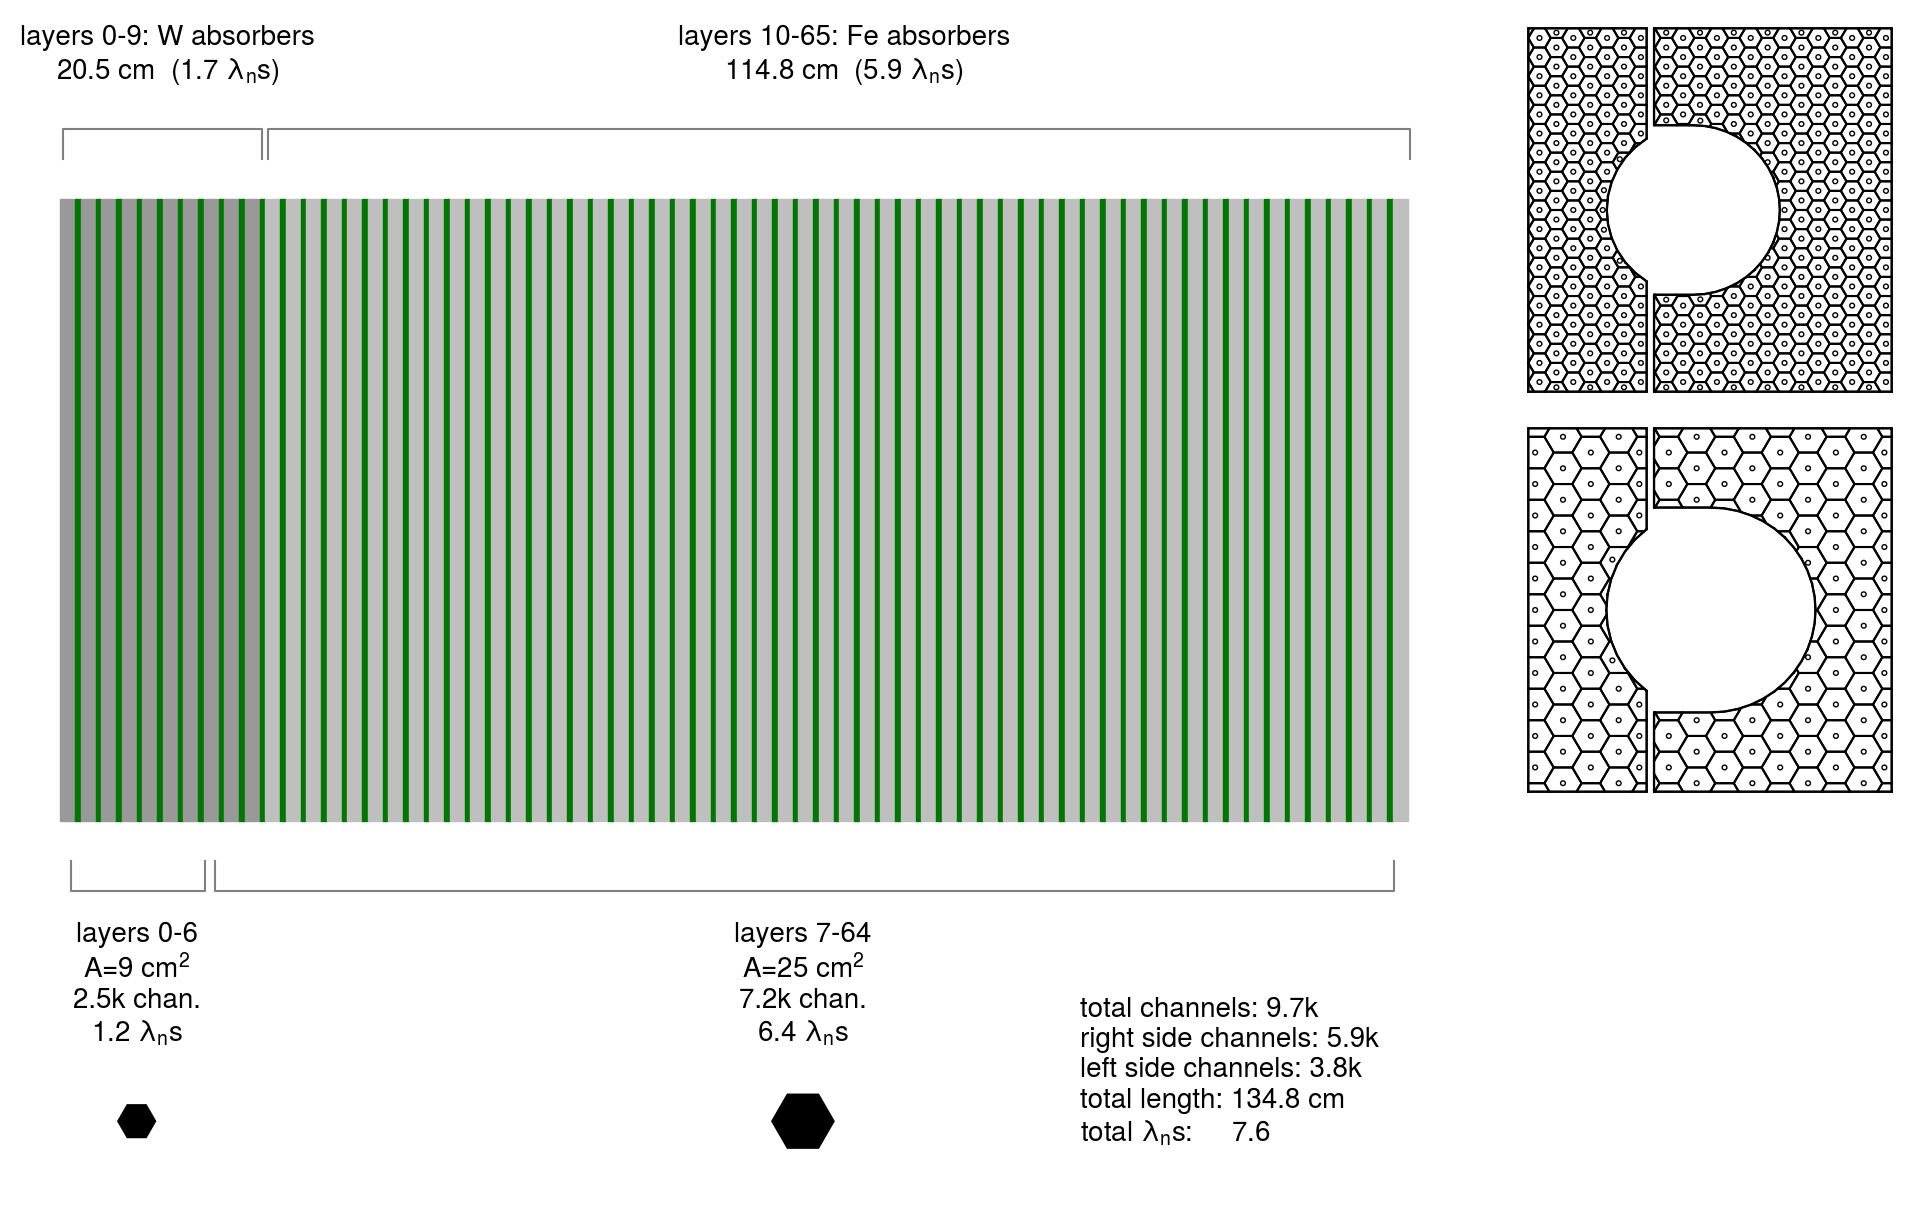

In [15]:
#draw the multi-layer structure:
#fig, axs=plt.subplots(1,1, figsize=(15, 12))

fig=plt.figure(figsize=(19,12))

axes=fig.add_axes([0,0,15/19,1])
plt.sca(axes)

coord_length=dp.coord_thickness
height=dp.det_height


txt_args=dict(fontsize=16)
txt_args=dict(fontsize=20)

abs_thk=dp.components['absorber'].thickness

#draw absorbers
for i in range(dp.n_layers+1):
    col="0.6" if dp.absorber_material[i]=="W" else '0.75'
    plt.gca().add_patch(mpl.patches.Rectangle((i*coord_length,-height/2), abs_thk, height, color=col))
    if i != dp.n_layers:
        plt.gca().add_patch(mpl.patches.Rectangle((i*coord_length+abs_thk,-height/2), dp.coord_thickness-abs_thk, height, color='#007700'))
    #plt.plot([i*coord_length]*2, [-height/2, height/2], color='#007733', linewidth=3)

#now draw braces showing different sections by cell size,
#along with hexagons and text info
if dp.nlarge!=0:
    ranges=(0,dp.nsmall-1), (dp.nsmall, dp.nsmall+dp.nmed-1), (dp.nsmall+dp.nmed, dp.n_layers-1)
    a=[dp.sidelengths[i] for i in (0, dp.nsmall, dp.nsmall+dp.nmed)] 
else:
    ranges=(0,dp.nsmall-1), (dp.nsmall, dp.nsmall+dp.nmed-1)
    a=[dp.sidelengths[i] for i in (0, dp.nsmall)] 
labels=[f"A={aa**2*3*np.sqrt(3)/2:.0f} cm$^2$" for aa in a]

for i in range(len(ranges)): 
    
    ai=a[i]
    r=ranges[i]
    x1,y1=(r[0]+r[1])/2*coord_length+abs_thk, height/2+12
    
    
    plt.plot([r[0]*coord_length-.4+abs_thk]*2+[r[1]*coord_length+.7+abs_thk]*2, 
             [-height/2-4, -height/2-7, -height/2-7, -height/2-4], color='0.5')
    nsides=2
    nlambda =sum([nlambda_per_layer[mat] for mat in summary.query(f'layer>={r[0]} and layer<={r[1]}').absorber_material])/nsides
    plt.text((r[0]+r[1])/2*coord_length+abs_thk, -height/2-22,
             f"layers {r[0]}-{r[1]}\n{labels[i]}\n{nchan[i]/1000.:.1f}k chan.\n{nlambda:.1f} $\lambda_n$s", ha='center',**txt_args)

#show hexagon sizes
phi=np.linspace(-np.pi, np.pi, 7)
for ai, r in zip(a, ranges):
    x=(r[0]+r[1])/2*coord_length+ai*np.cos(phi)+abs_thk
    y=-height/2-30+ai*np.sin(phi)
    plt.gca().add_patch(mpl.patches.Polygon(list(zip(x,y)), color='k'))


#now draw braces showing different sections by absorber material
ranges=(0,dp.nW-1), (dp.nW, dp.n_layers)
labels=["W absorbers", "Fe absorbers"]

for i in range(len(ranges)): 
    
    
    
    r=ranges[i]
    plt.plot([r[0]*coord_length+.3]*2+[(r[1]+1)*coord_length-.3]*2, 
             [height/2+4, height/2+7, height/2+7, height/2+4], color='0.5')
    nsides=2
    nlambda =sum([nlambda_per_layer[mat] for mat in summary.query(f'layer>={r[0]} and layer<={r[1]}').absorber_material])/nsides
    length=dp.coord_thickness*(r[1]+1-r[0])
    
    
    
    
    plt.text((r[0]+r[1])/2*coord_length+abs_thk, height/2+12,
             f"layers {r[0]}-{r[1]}: {labels[i]}\n{length:.1f} cm  ({nlambda:.1f} $\lambda_n$s)", ha='center',**txt_args)

    
    
#label for totals

nsides=2
nlambda =sum([nlambda_per_layer[mat] for mat in summary.absorber_material])/nsides    

length=dp.n_layers*dp.coord_thickness+dp.components['absorber'].thickness

plt.text(102, -height/2-32, 
         f"total channels:\t{tot_chan/1000.:.1f}k\n" \
         +f"right side channels:\t{tot_chan_right/1000:.1f}k\n"\
         +f"left side channels:\t{(tot_chan-tot_chan_right)/1000.:.1f}k\n"\
         +f"total length:\t{length:.1f} cm\n"\
         +f"total $\lambda_n$s:\t{nlambda:.1f}",**txt_args)

plt.xlim(-5, 145)
plt.ylim(-70, 50)
plt.gca().axis('off')

#now make representative tiles on separate axes
rep_layers=(0, dp.nmed, dp.nmed+dp.nsmall) if dp.nlarge != 0 else  (0, dp.nmed)
for i in range(len(rep_layers)):
    layer=rep_layers[i]
    ax = fig.add_axes([15/19, (2-i)/3, 4/19, 1/3])
    plt.sca(ax)
    #plt.title(f"layer {layer}")
    arg=dict(fillDimple=False, color='k')
    draw_layer(layer, **arg, sidelength=dp.sidelengths[layer], shade_deadzone=False)
    plt.gca().invert_xaxis()
    plt.axis('off')
        
#plt.tight_layout()
plt.show()


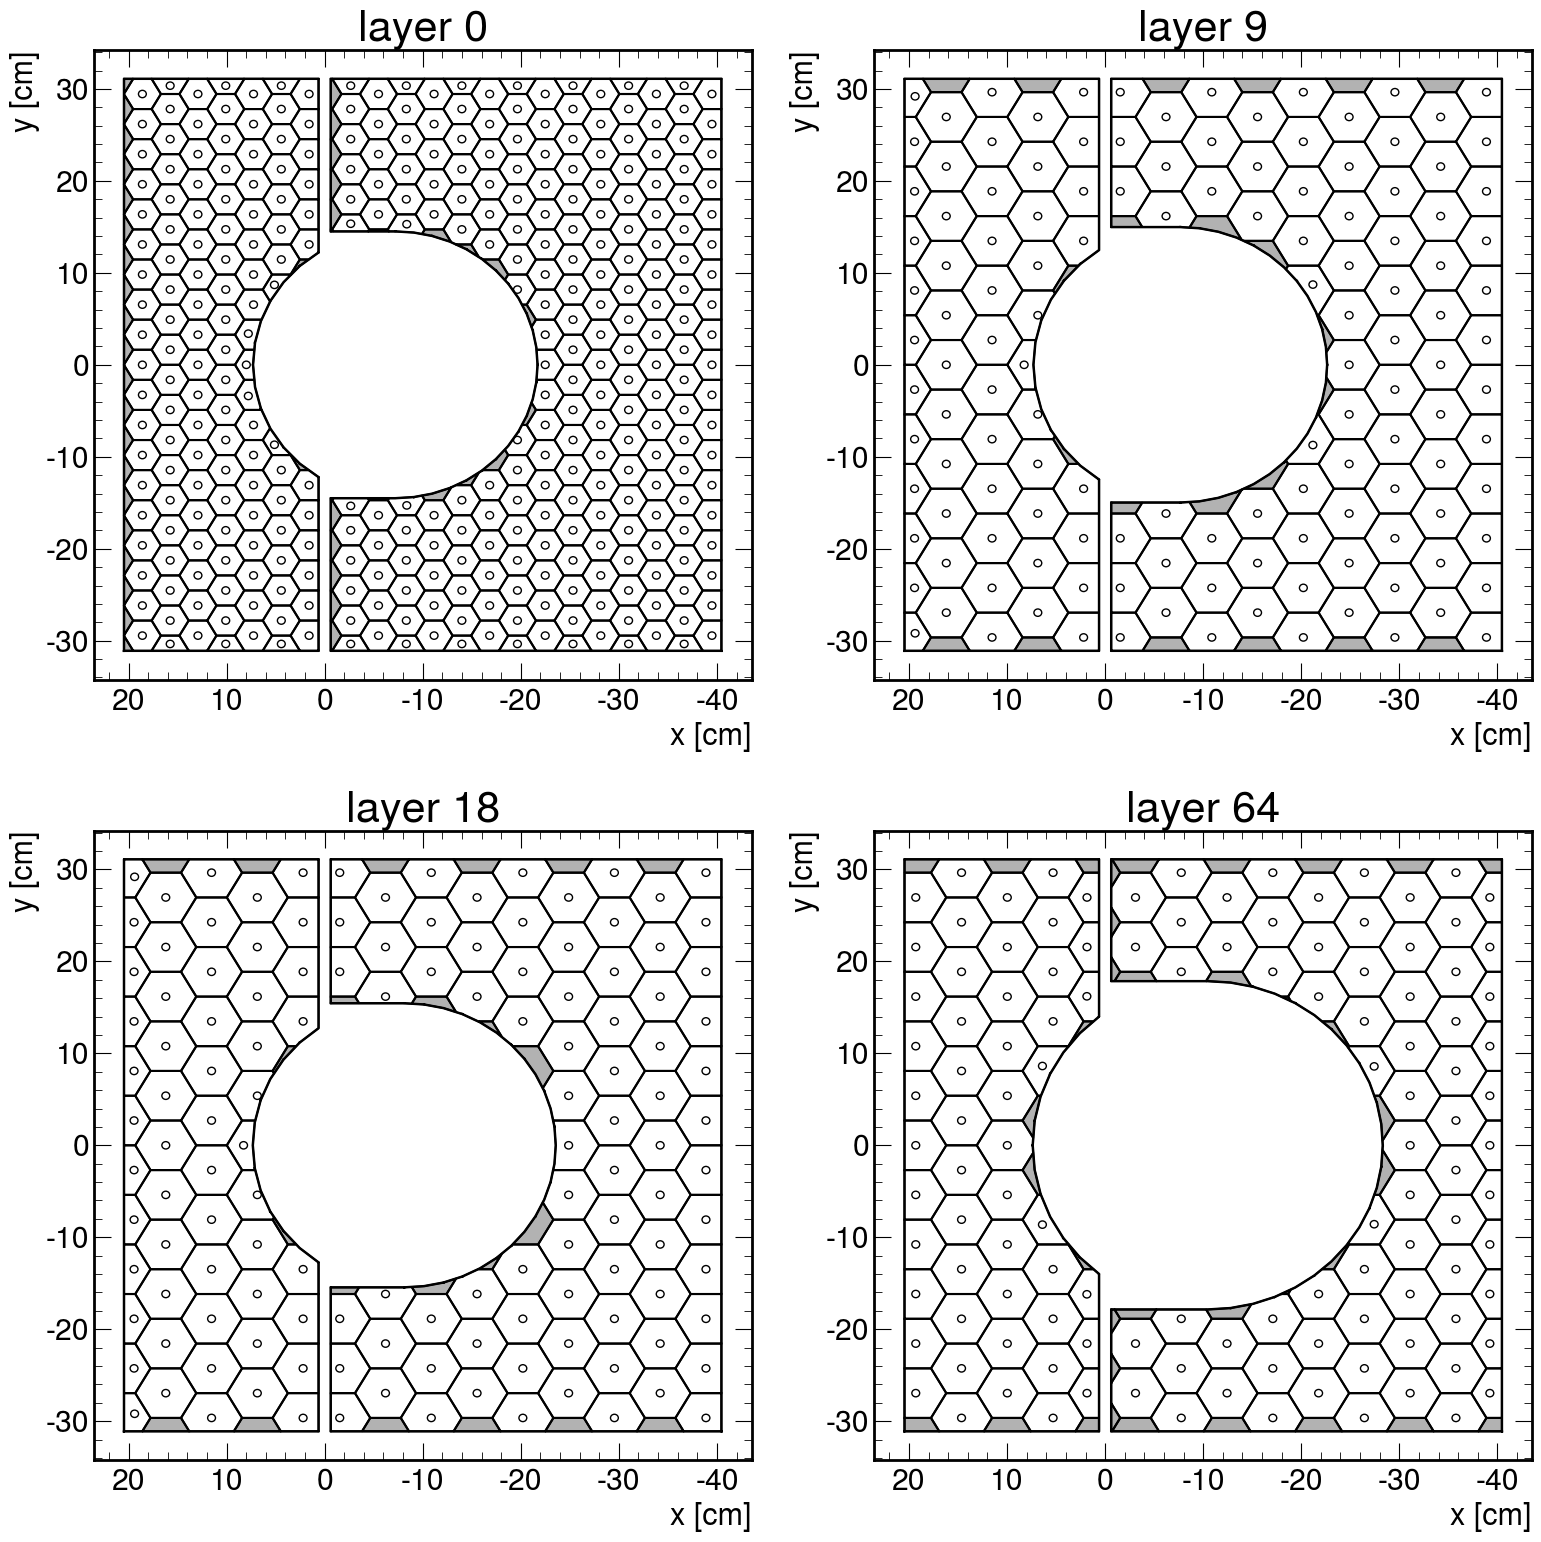

In [16]:
arg=dict(fillDimple=False, color='k')
fig,axs=plt.subplots(2,2, figsize=(16,16))
for i,layer in enumerate((0, 9, 18, dp.n_layers-1)):

    plt.sca(axs[i//2][i%2])
    plt.title(f"layer {layer}")
    draw_layer(layer, **arg, sidelength=dp.sidelengths[layer])
    plt.gca().invert_xaxis()
for row in axs:
    for ax in row:
        ax.set_xlabel("x [cm]", fontsize=22)
        ax.set_ylabel("y [cm]", fontsize=22)
        
plt.tight_layout()
plt.savefig(f"representative_layers.pdf")
plt.show()

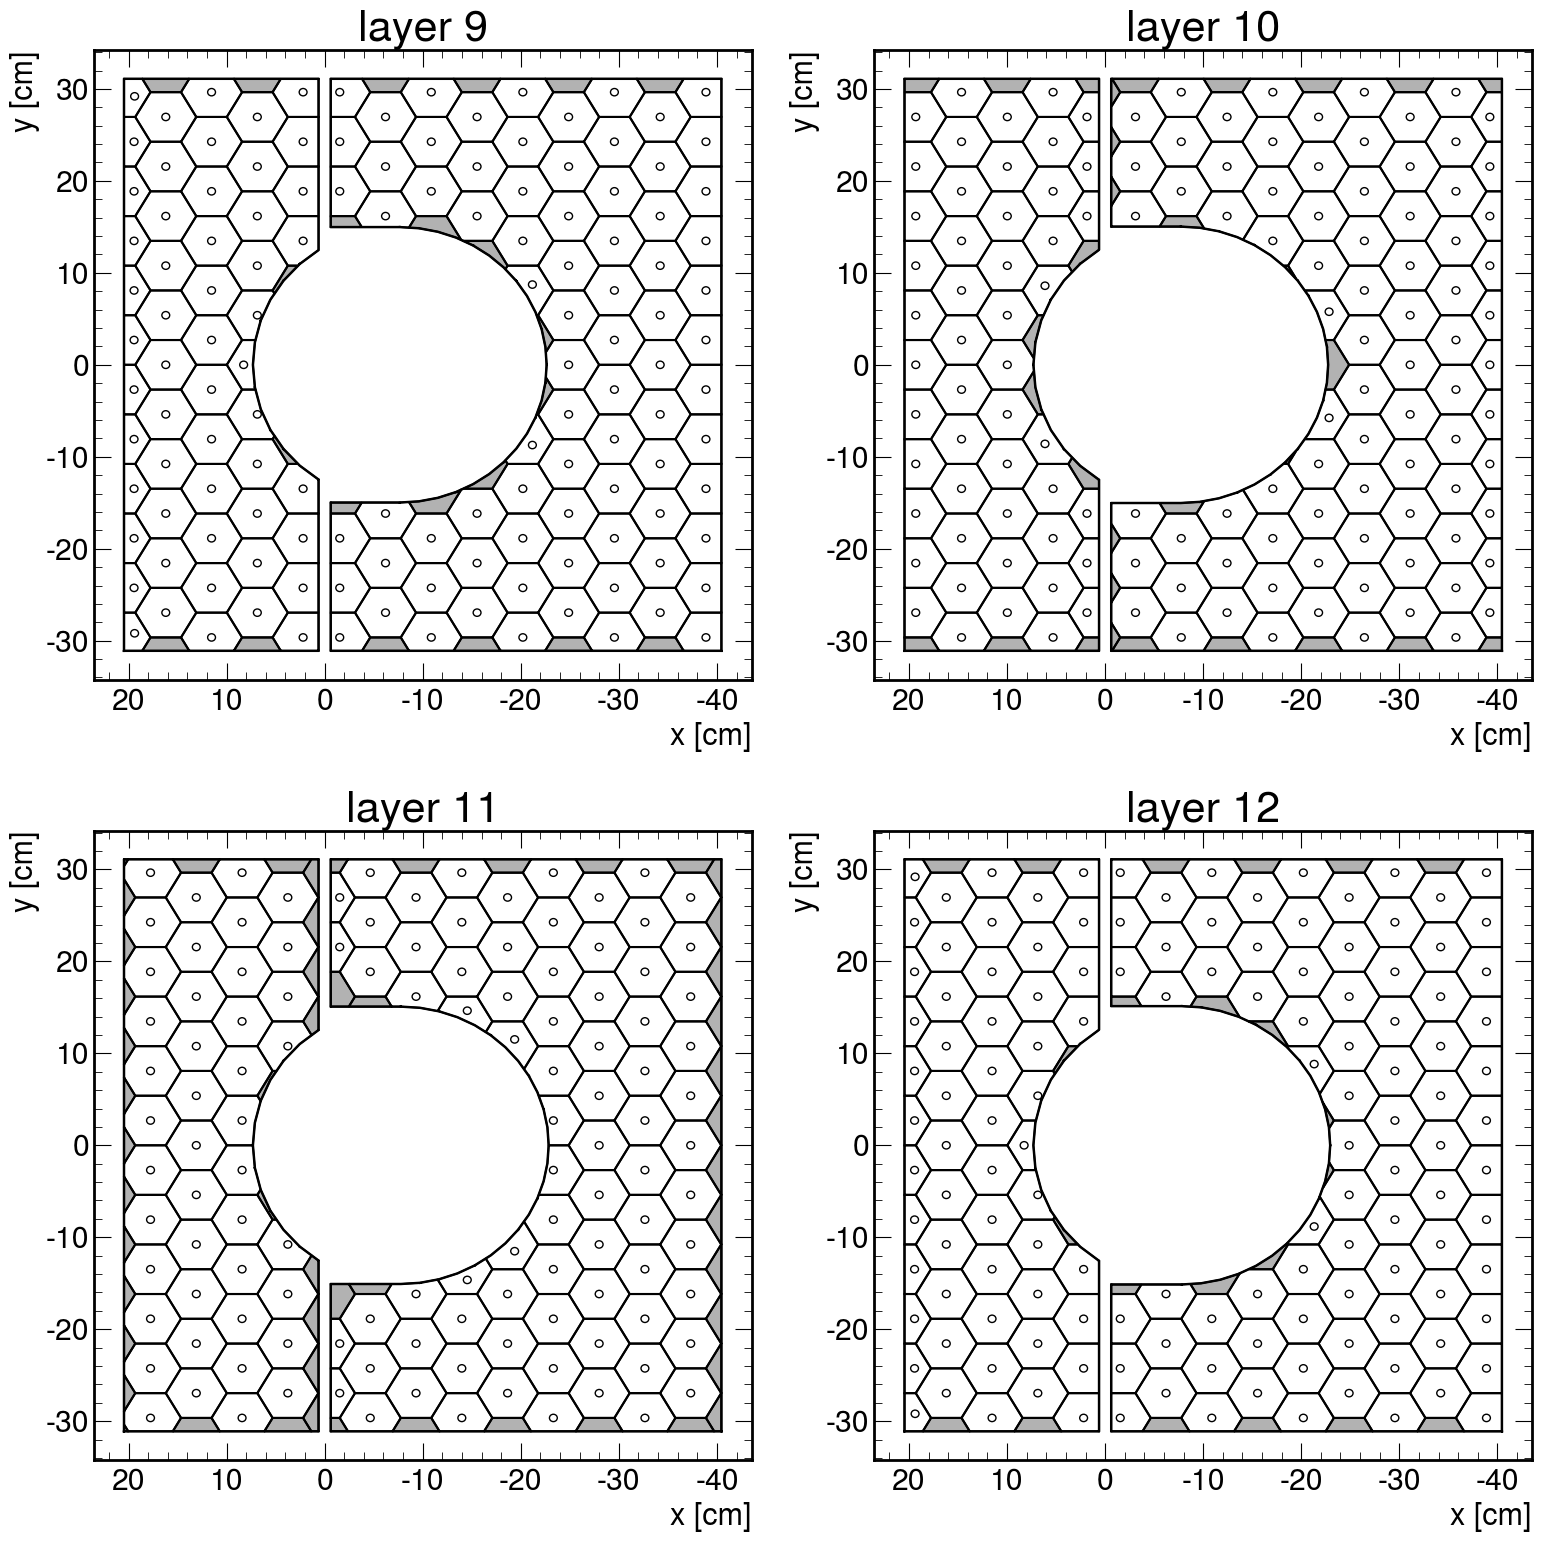

In [17]:
sidelengths[9]*np.sqrt(3)/2


arg=dict(fillDimple=False, color='k')
fig,axs=plt.subplots(2,2, figsize=(16,16))
for i,layer in enumerate((9, 10, 11,12)):

    plt.sca(axs[i//2][i%2])
    plt.title(f"layer {layer}")
    draw_layer(layer, **arg, sidelength=sidelengths[layer])
    plt.gca().invert_xaxis()
for row in axs:
    for ax in row:
        ax.set_xlabel("x [cm]", fontsize=22)
        ax.set_ylabel("y [cm]", fontsize=22)
        
plt.tight_layout()
#plt.savefig(f"representative_layers.pdf")
plt.show()

KeyboardInterrupt: 

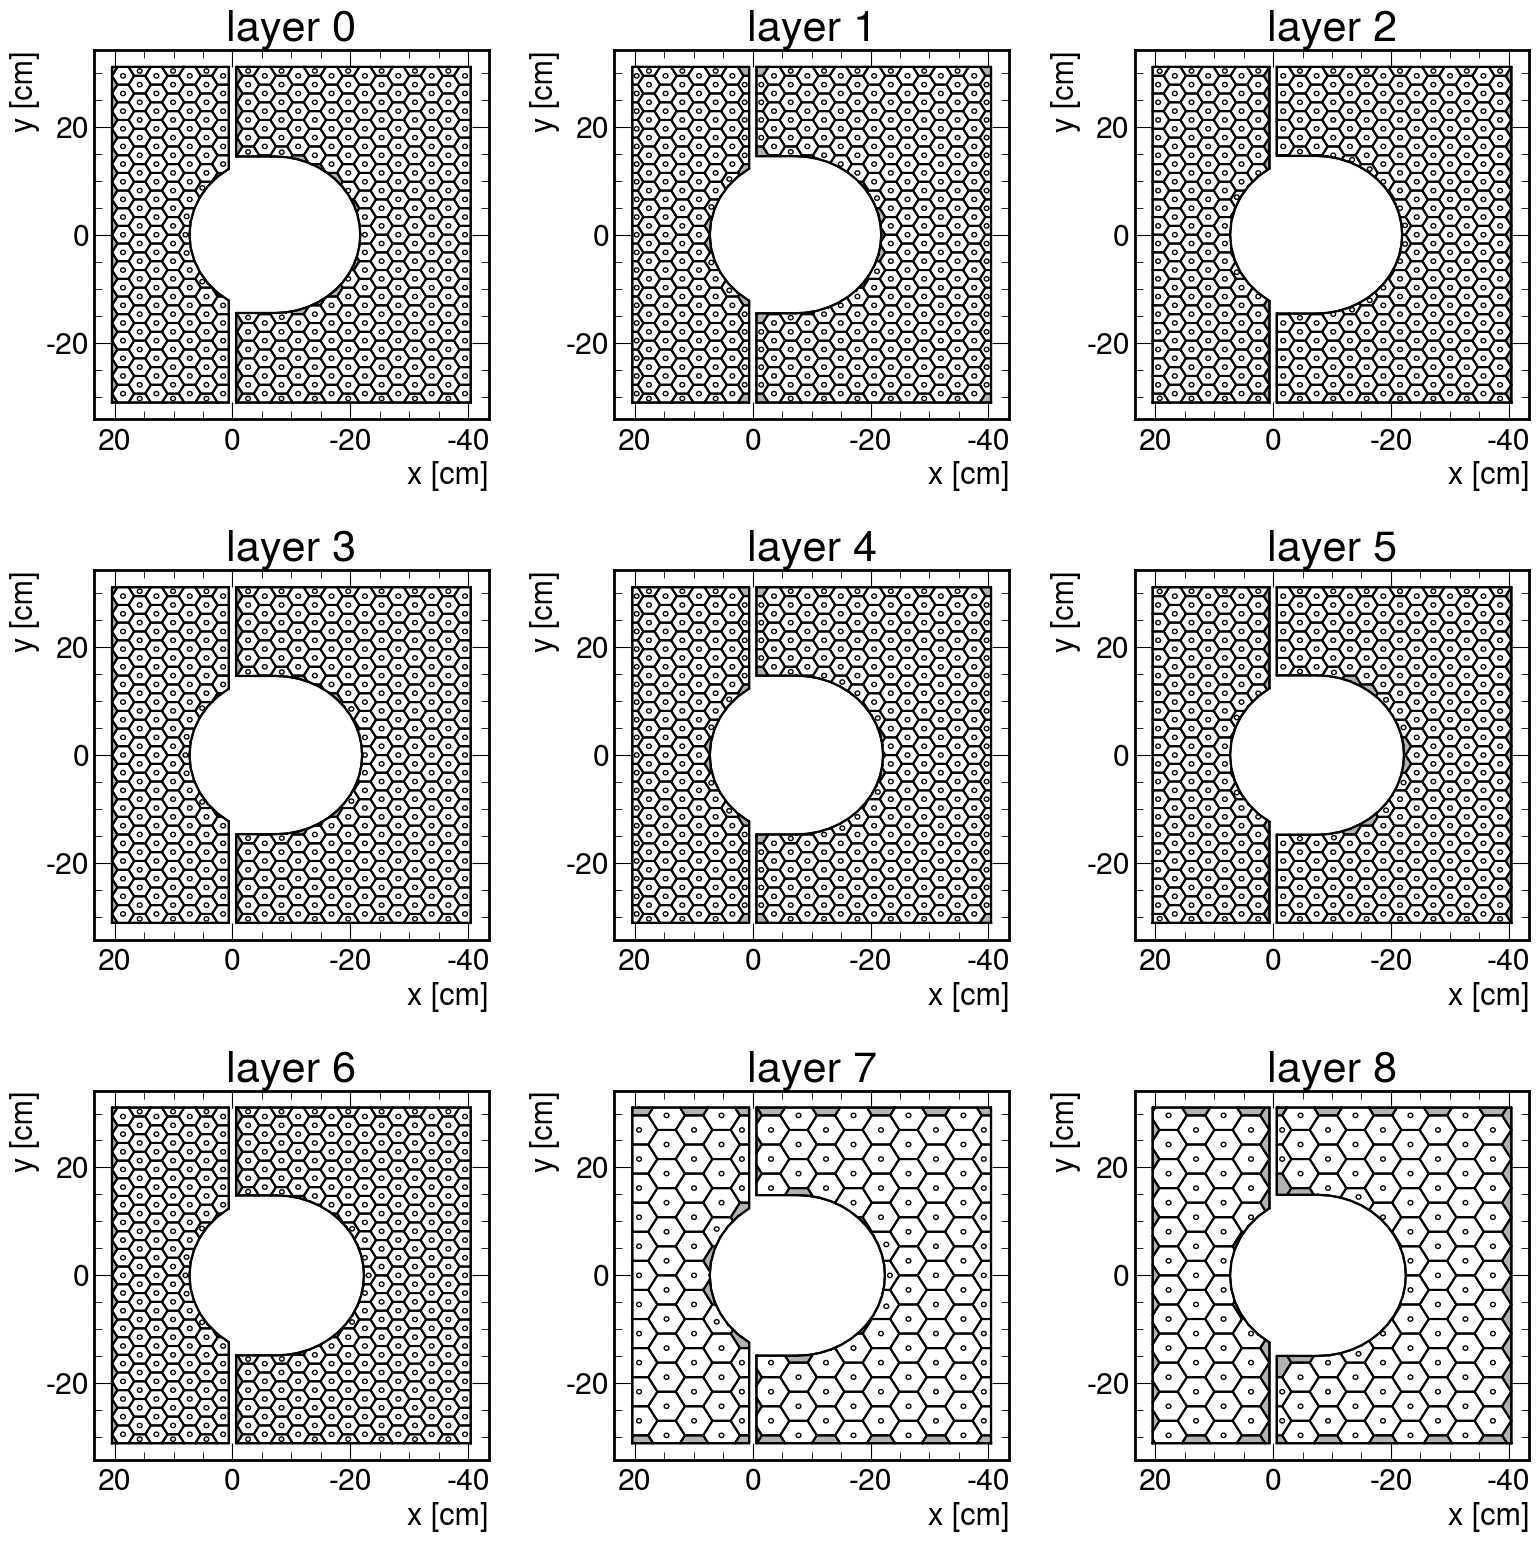

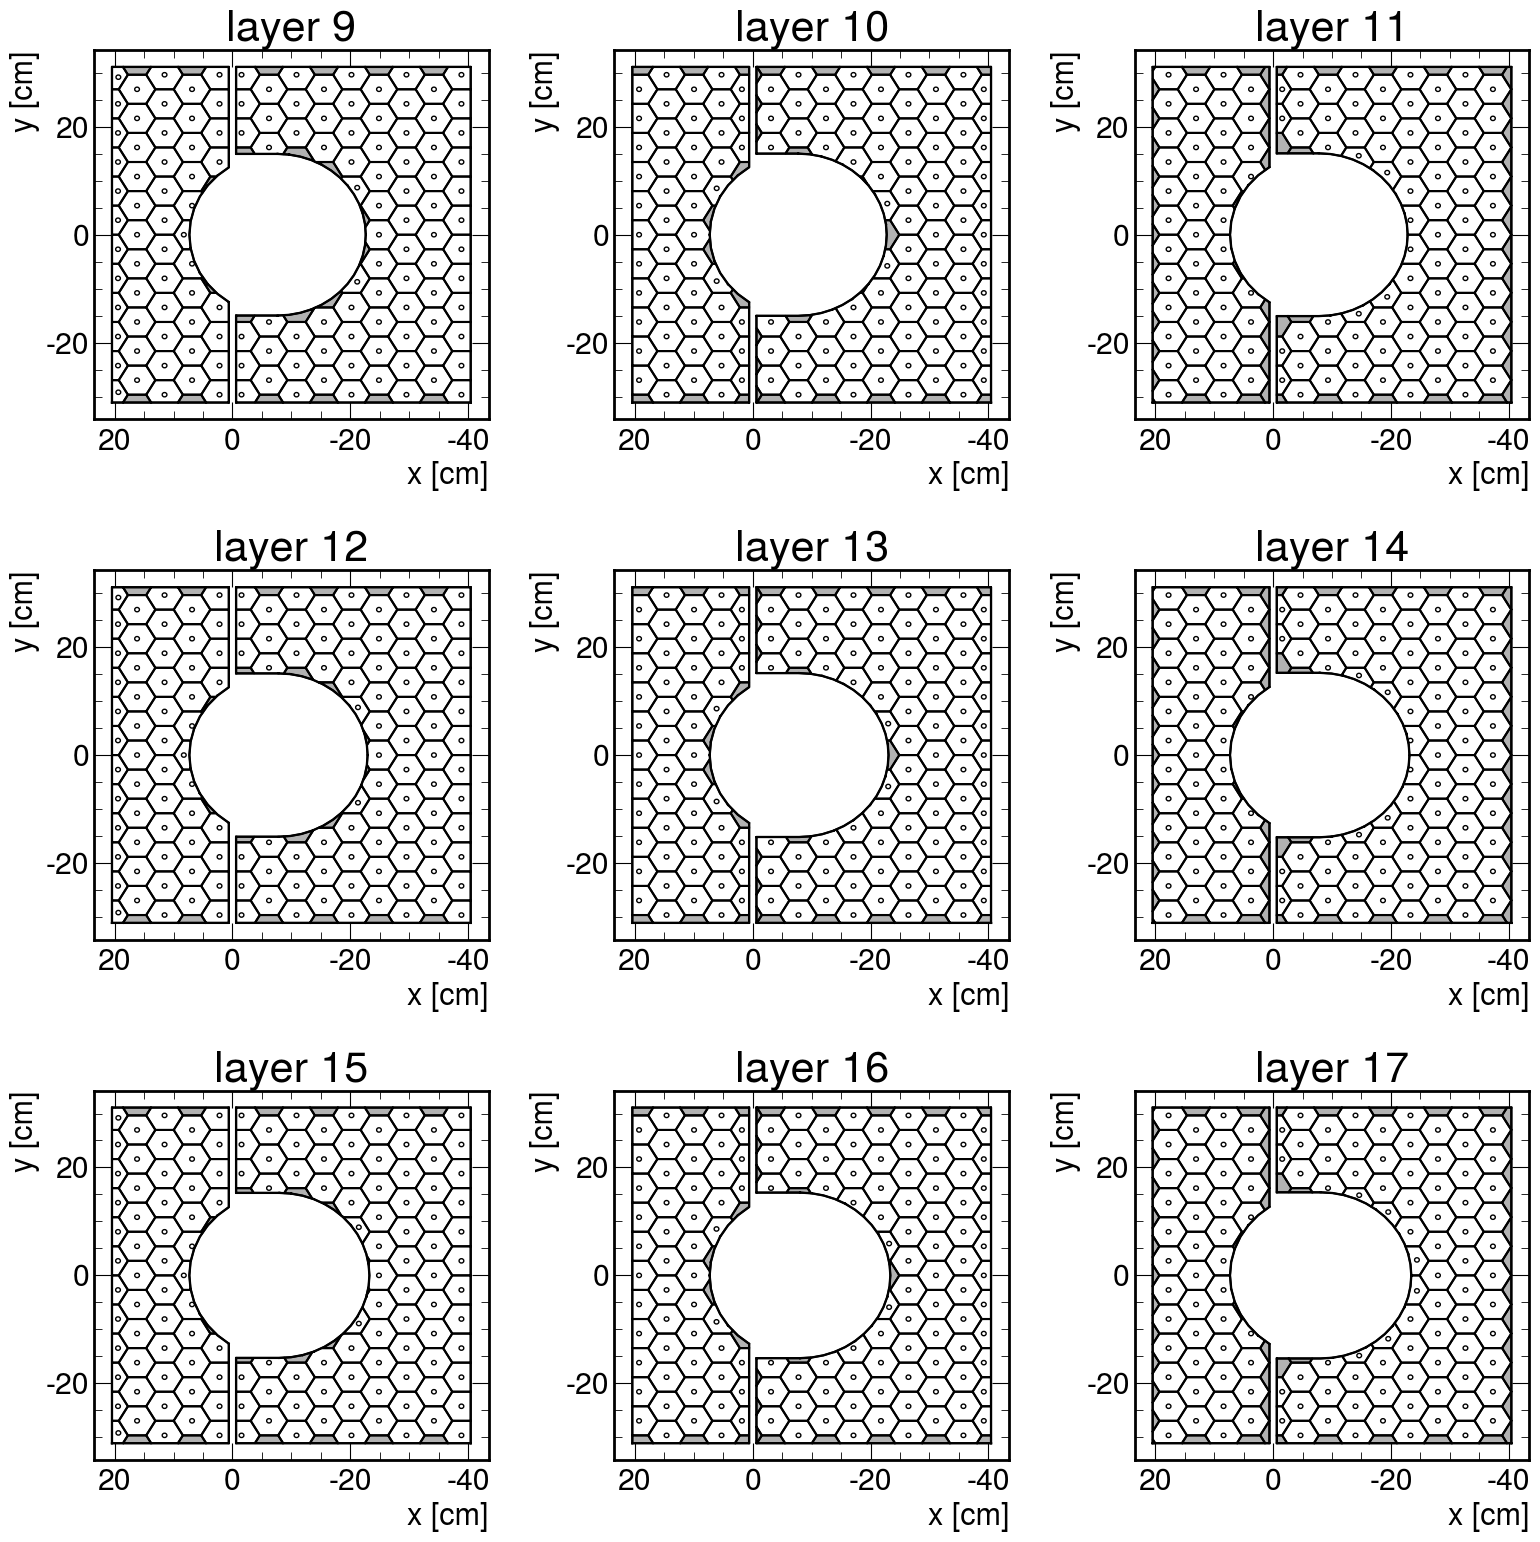

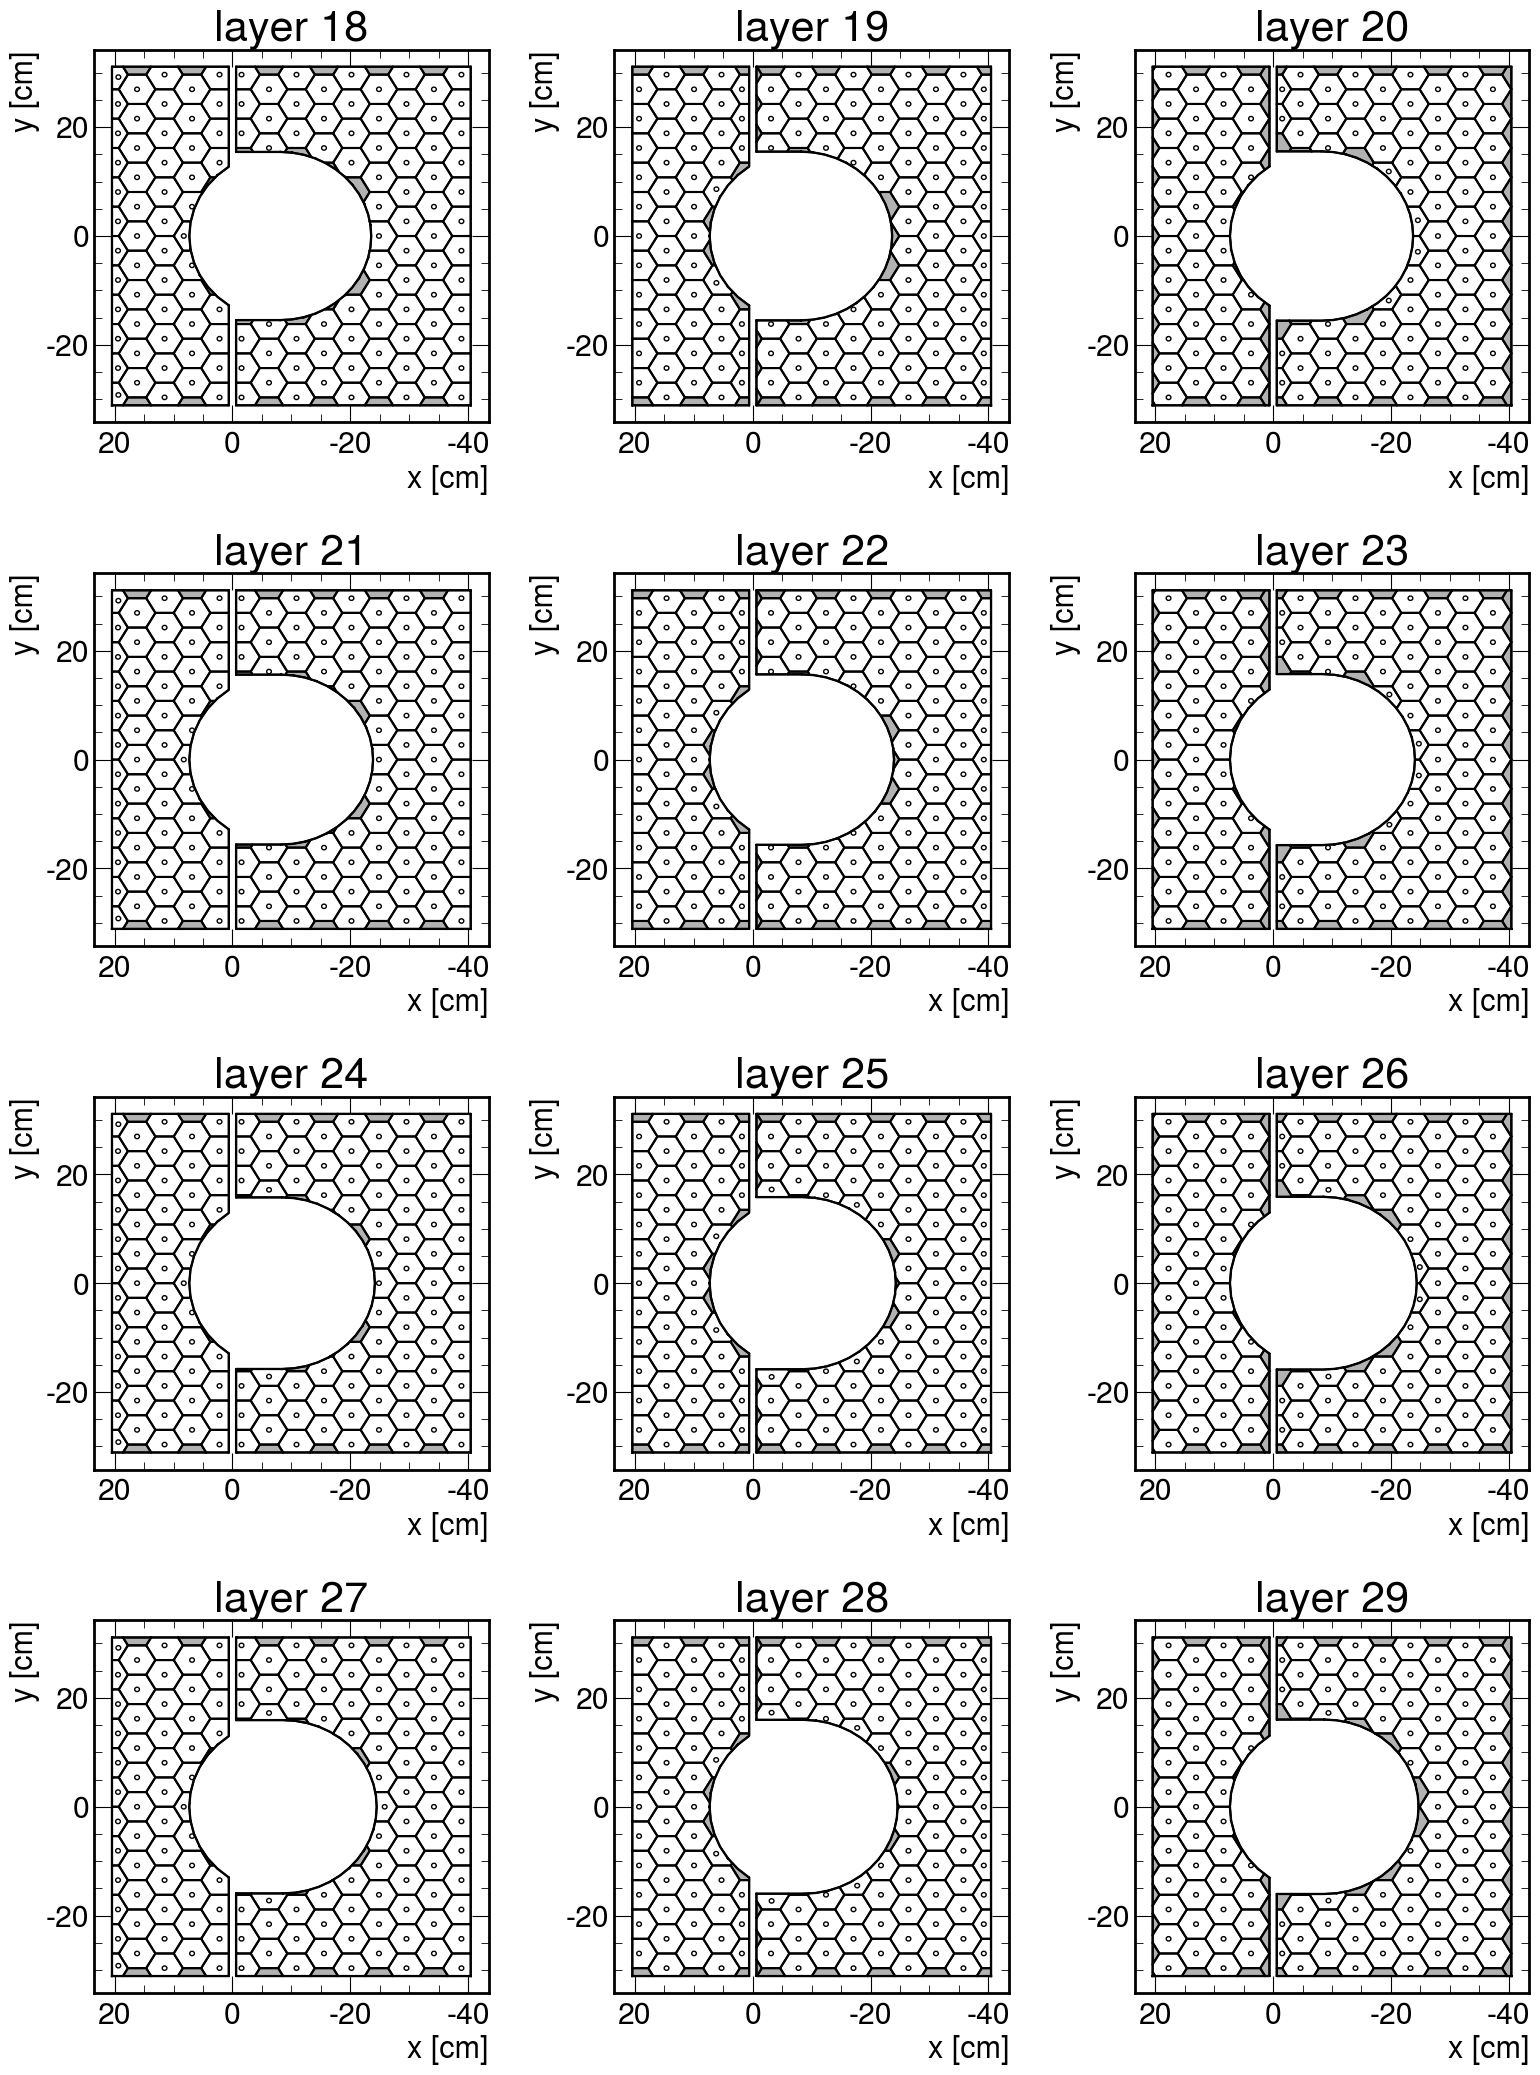

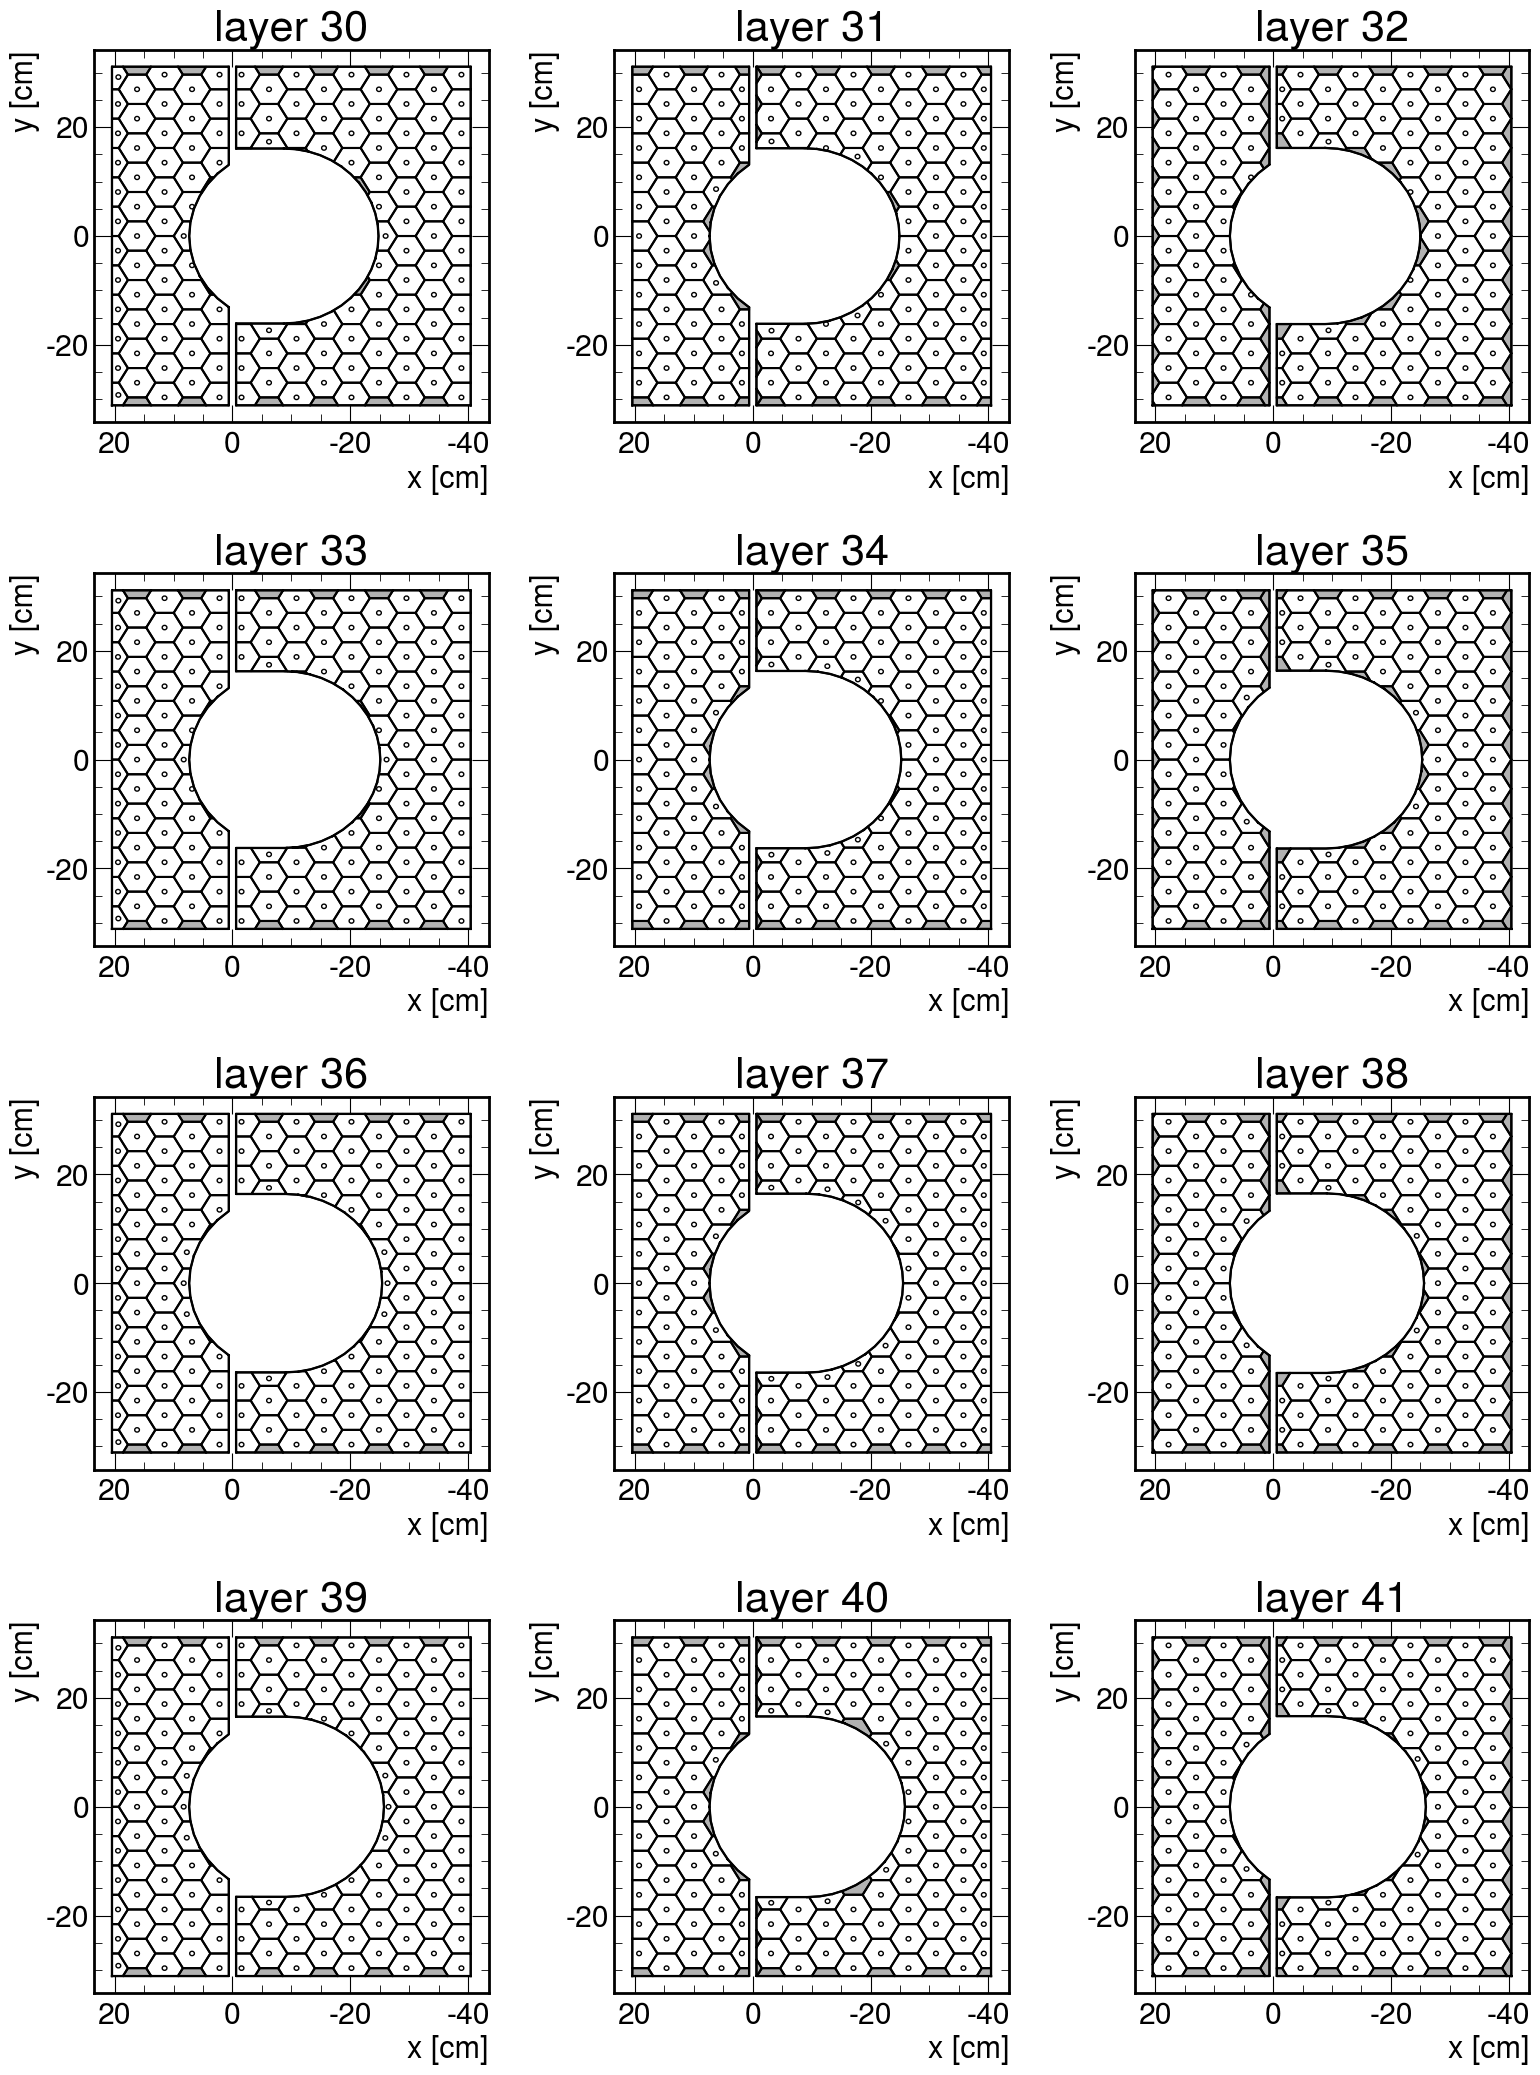

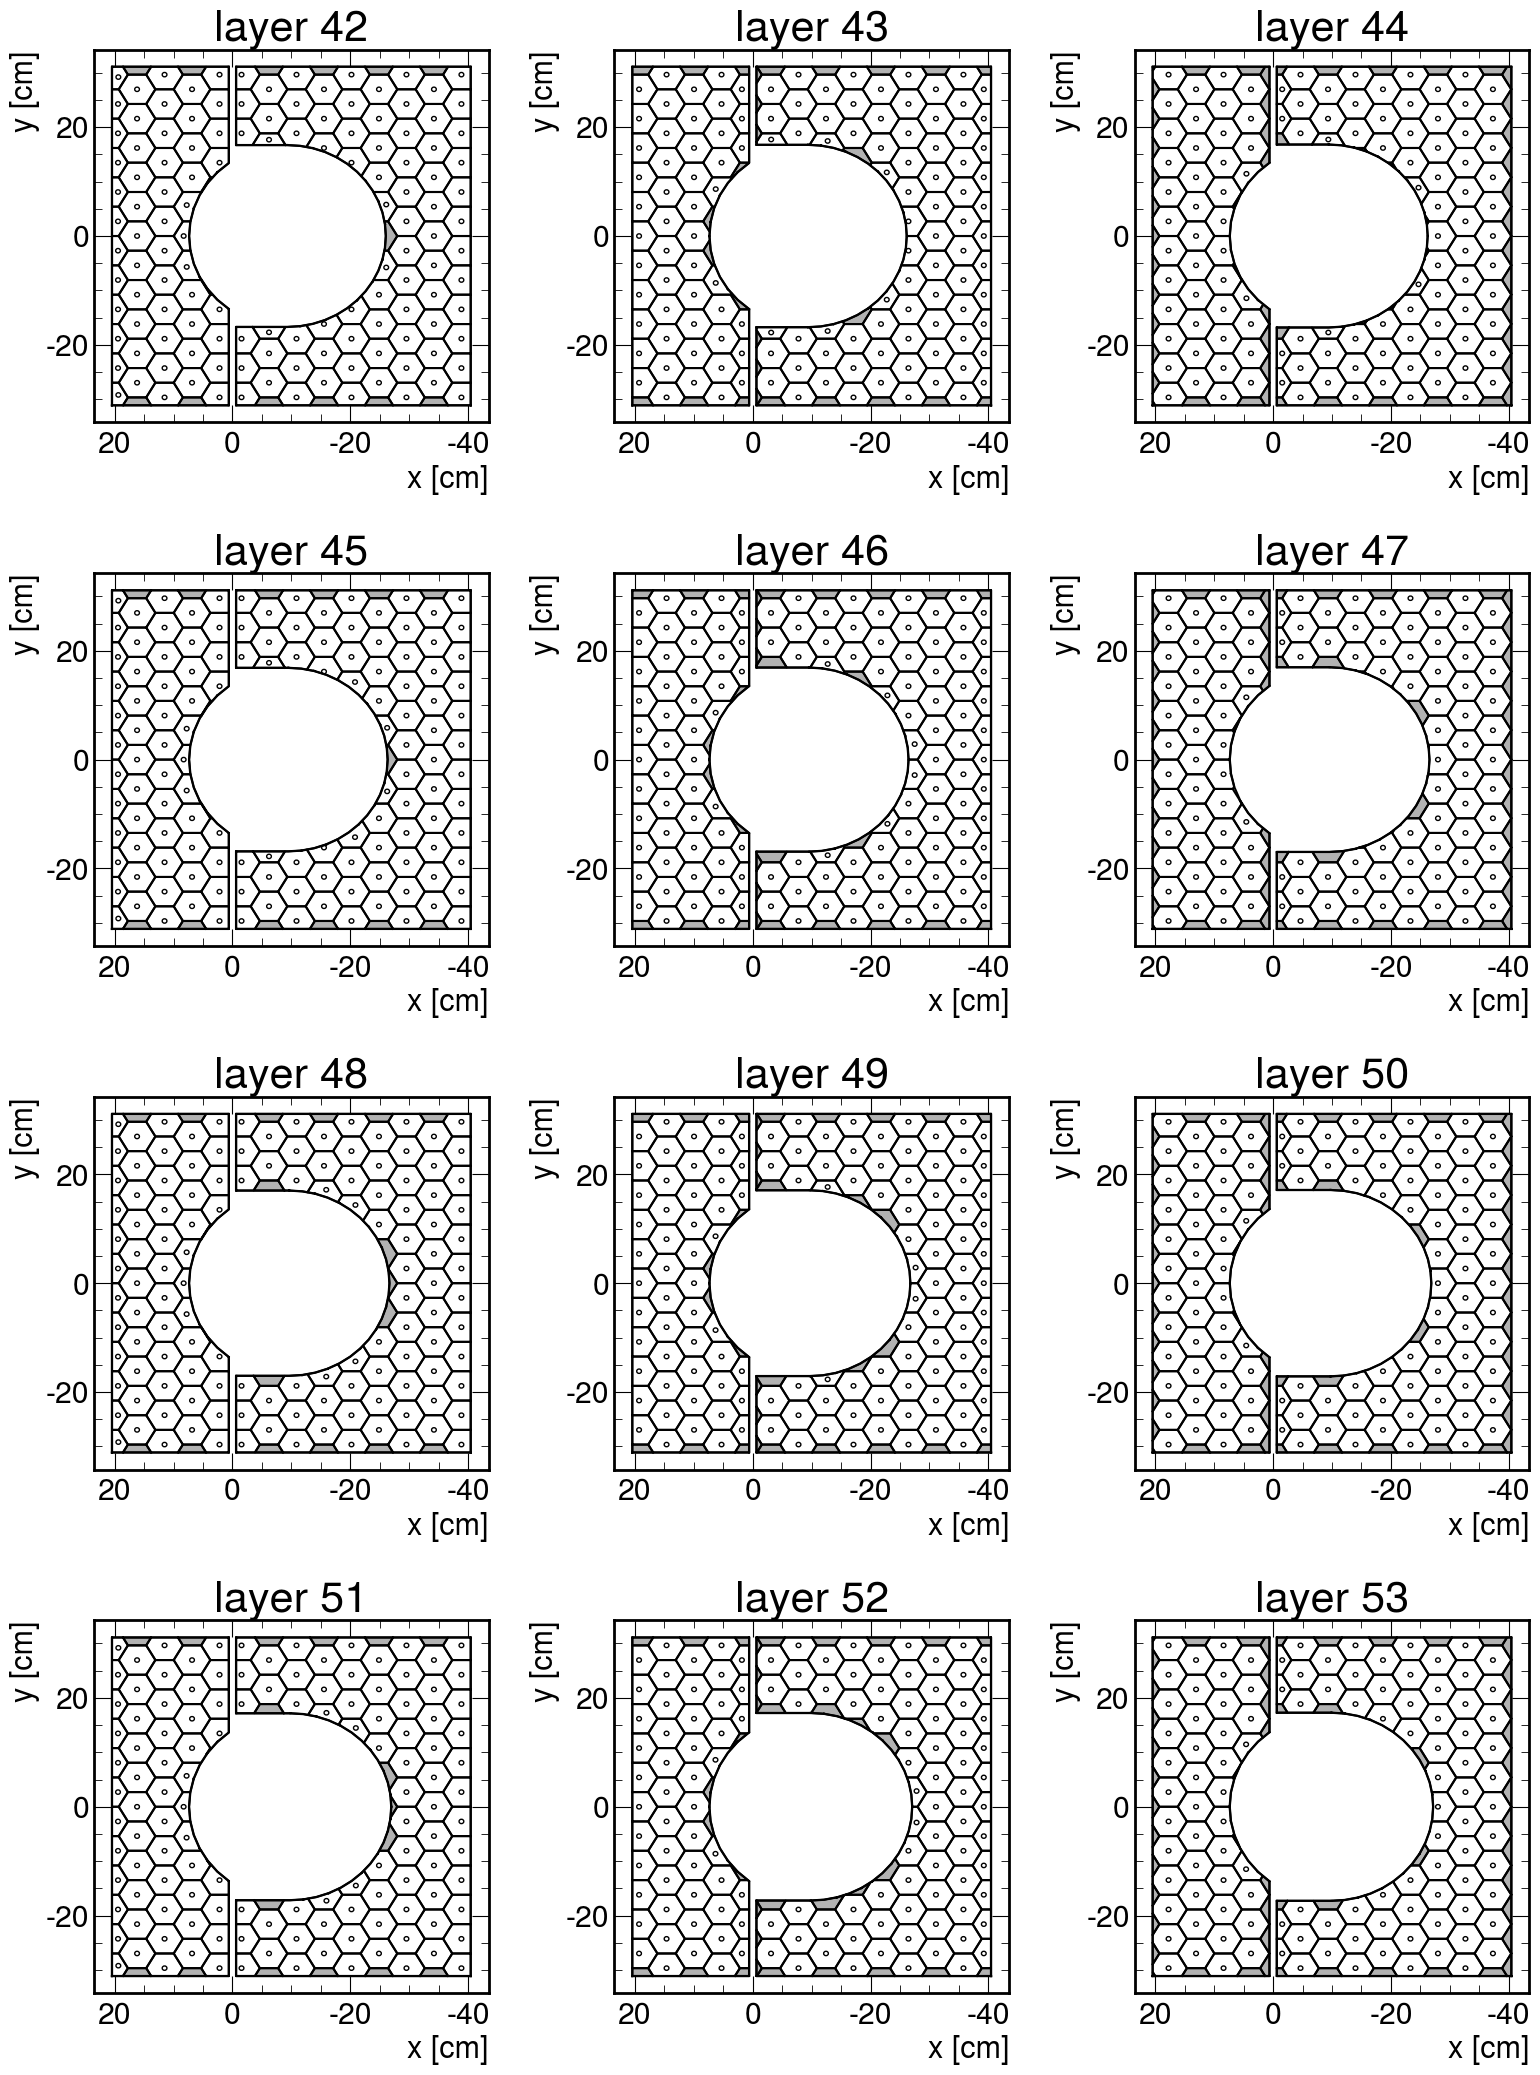

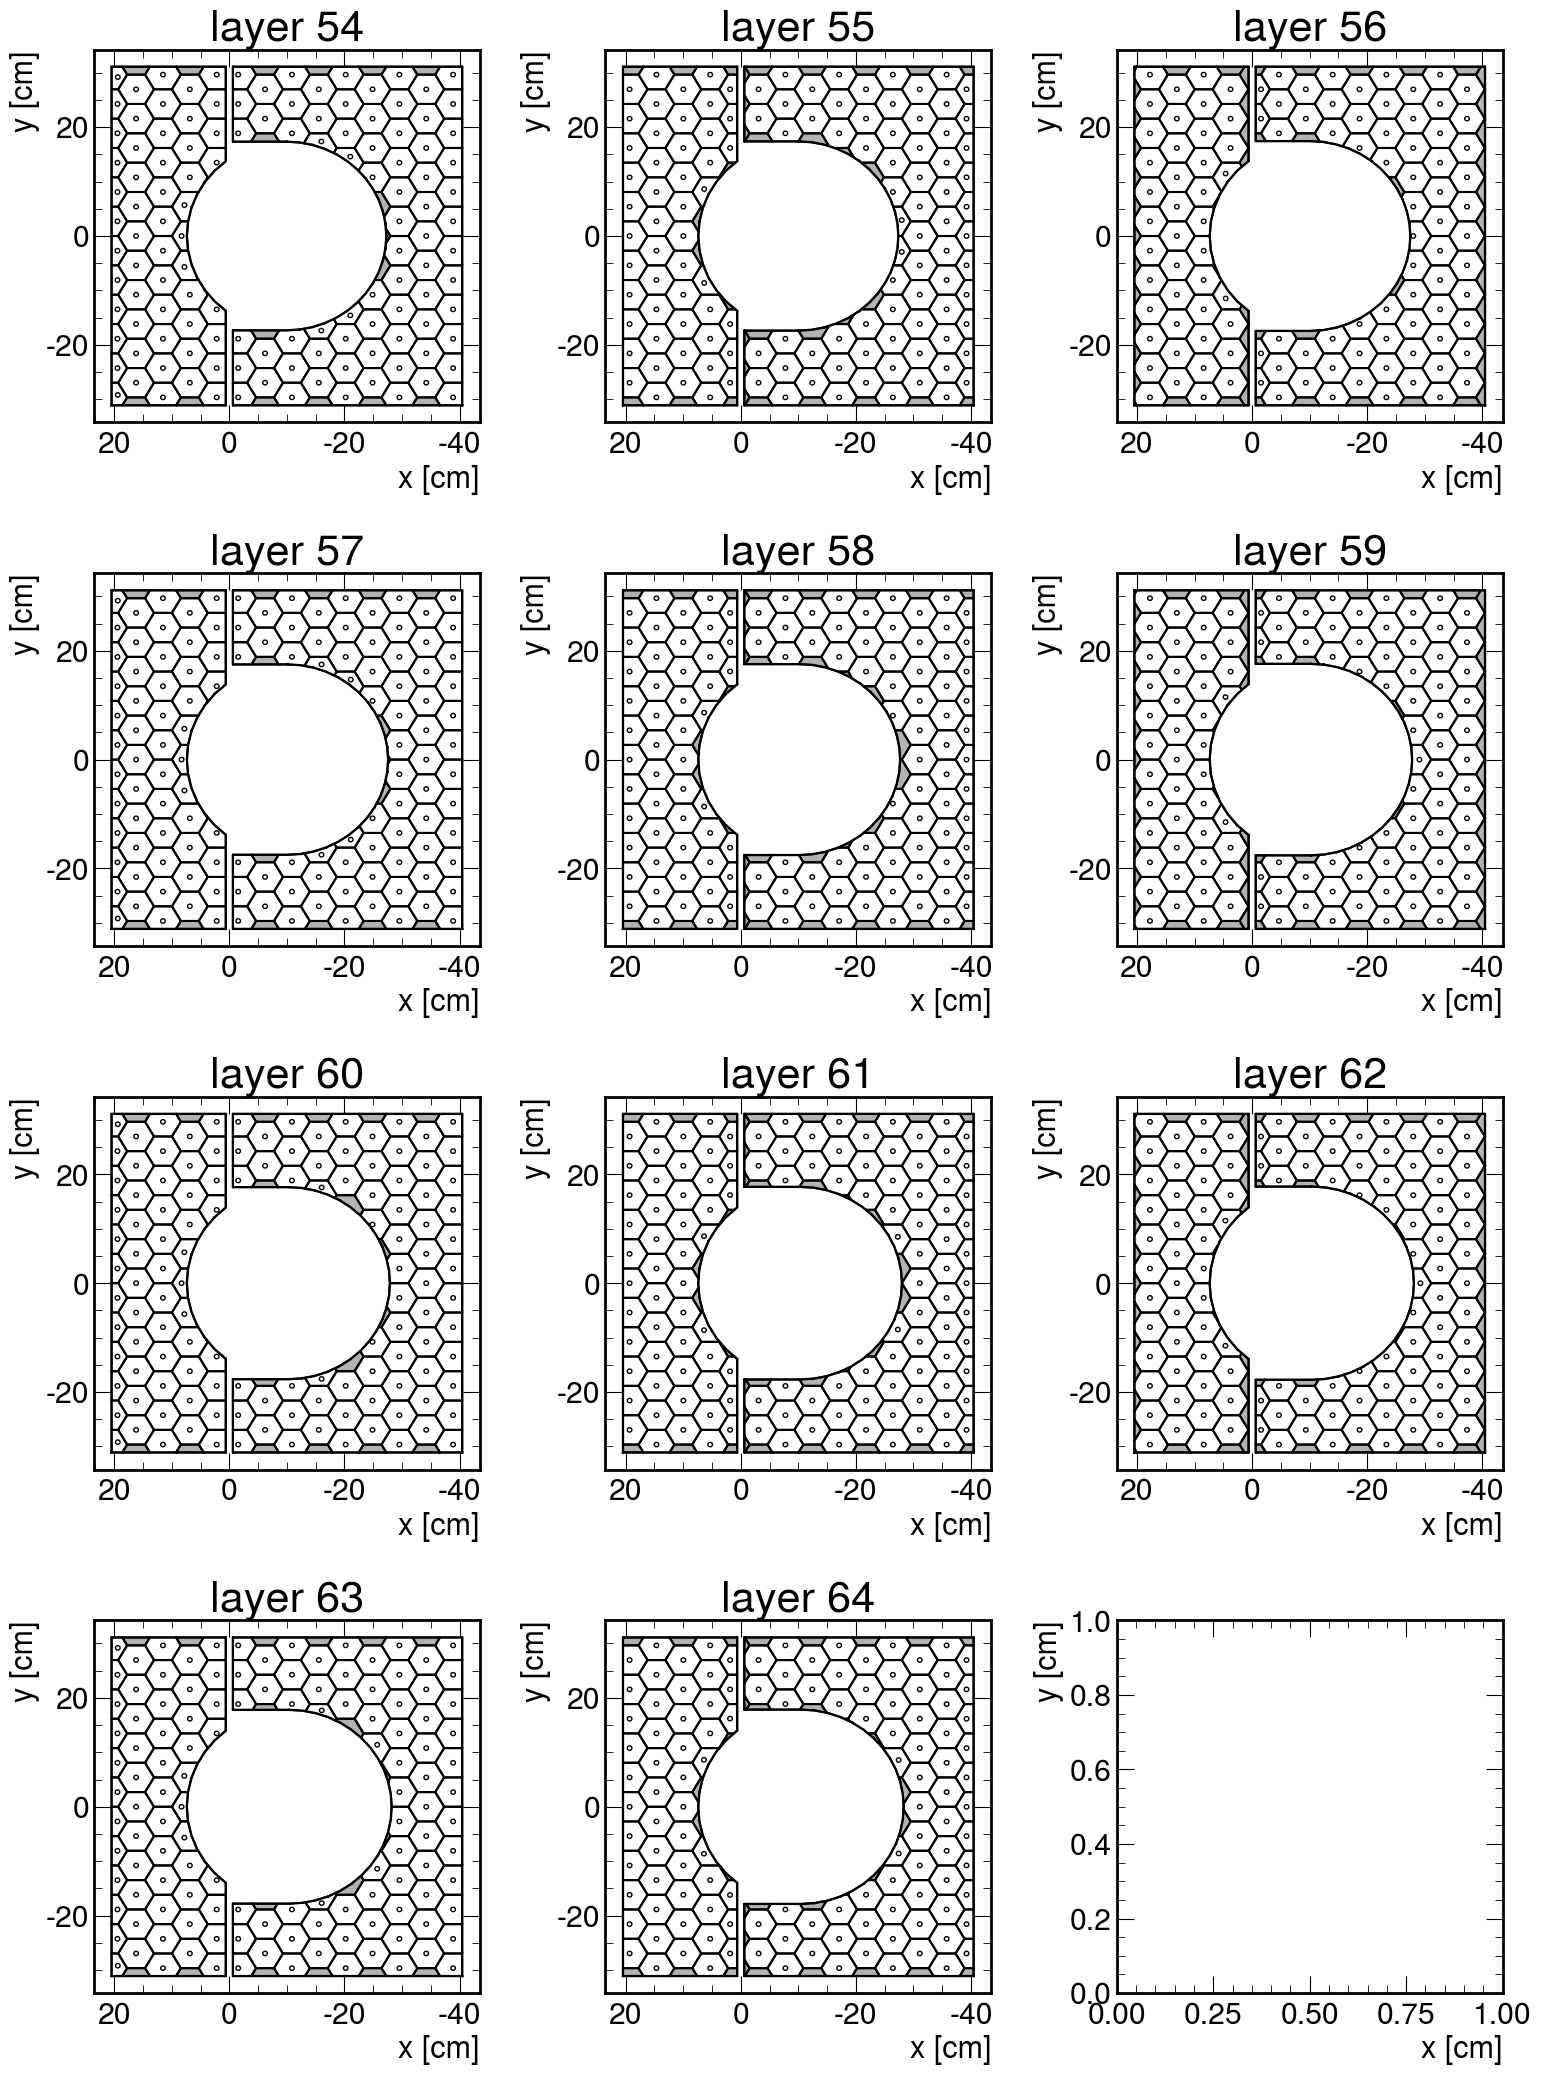

In [18]:
#now make a multi-page pdf with all of the layers
# Instantiating PDF document
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('all_layers_layout.pdf')

for j in range(6):

    arg=dict(fillDimple=False, color='k')
    nrows = 3 if j < 2 else 4
    fig,axs=plt.subplots(nrows,3, figsize=(16,16*nrows/3))
    for i in range(3*nrows):
        layer = j*9+i if j<2 else 18+(j-2)*12+i 
        if layer==dp.n_layers:
            break
        plt.sca(axs[i//3][i%3])
        plt.title(f"layer {layer}")
        draw_layer(layer, **arg, sidelength=sidelengths[layer])
        plt.gca().invert_xaxis()
    for row in axs:
        for ax in row:
            ax.set_xlabel("x [cm]", fontsize=22)
            ax.set_ylabel("y [cm]", fontsize=22)

    plt.tight_layout()
    # Saving figures on pdf pages
    pdf.savefig(fig)
    #plt.savefig(f"representative_layers.pdf")
plt.show()

In [ ]:
tot_dz={}
for s in "LR":
    df =summary.query(f"side=='{s}'")
    plt.plot(df.layer, df.deadzone_frac, label=s)
    
dfL=summary.query(f"side=='L'")
dfR=summary.query(f"side=='R'")

plt.plot(np.array(dfR.layer), (np.array(dfL.deadzone_area)+np.array(dfR.deadzone_area))/
         (np.array(dfL.tot_area)+np.array(dfR.tot_area)), label="L,R combined", color='0.5', linestyle='--')

plt.axhline(np.sum(summary.deadzone_area)/np.sum(summary.tot_area), linestyle=':', color='g', label='average')

plt.legend()
plt.xlabel("layer")
plt.ylabel("deadzone fraction")
plt.ylim(0)

In [33]:
all_layers[(0, "L")].scint_boundsx[101]

array('d', [12.002867513459483, 13.83413248654052, 14.749764973081039, 13.83413248654052, 12.002867513459483, 11.087235026918965, 12.002867513459483])

In [35]:
2*(13.83413248654052-14.749764973081039)

-1.831264973081037

# create openscad file and STLs for the 3d-printed frames

In [ ]:
def write_for_openscad(df, file=None, wall_thickness=dp.wall_thickness, frame_height=0.3):
    cm=10
    segments=[]
    print("segments=[", file=file)
    lines=[]
    #keep track of 90 degree corners, so that they can be made 90 degree square corners instead of rounded
    corners=[]
    for i in range(len(df)):
        for j in range(len(df.boundsx[i])-1):
            segment = {(df.boundsx[i][j], df.boundsy[i][j]), (df.boundsx[i][j+1], df.boundsy[i][j+1])}
            tol=1e-6
            if j!=0 and (abs(df.boundsx[i][j]-df.boundsx[i][j+1])<tol and abs(df.boundsy[i][j]-df.boundsy[i][j-1])<tol \
                      or abs(df.boundsy[i][j]-df.boundsy[i][j+1])<tol and abs(df.boundsx[i][j]-df.boundsx[i][j-1])<tol) or \
                j==0 and (abs(df.boundsx[i][j]-df.boundsx[i][j+1])<tol and abs(df.boundsy[i][j]-df.boundsy[i][-2])<tol \
                       or abs(df.boundsy[i][j]-df.boundsy[i][j+1])<tol and abs(df.boundsx[i][j]-df.boundsx[i][-2])<tol):
                corner = (df.boundsx[i][j], df.boundsy[i][j])
                #print(corner)
                if corner not in corners:
                    corners.append(corner)
            if segment not in segments:
                lines.append(f"[[{cm*df.boundsx[i][j]:.3f},{cm*df.boundsy[i][j]:.3f}], [{cm*df.boundsx[i][j+1]:.3f}, {cm*df.boundsy[i][j+1]:.3f}]]")
                segments.append(segment)
        #print()
    print(",\n".join(lines), file=file)
    print("];", file=file)
    
    #add points for square corners if applicable.  
    if corners:
        print("corners=[", file=file)
        lines=[]
        for corner in corners:
            lines.append(f"  [{cm*corner[0]:.3f}, {cm*corner[1]:.3f}]")
        print(",\n".join(lines)+"\n];", file=file)
    else:
        print("corners=[];", file=file)
    print(f"wall_thickness={wall_thickness*cm};\nframe_height={frame_height*cm};", file=file)
    print(f"include <make_3d_frame.scad>", file=file)

In [ ]:
#now test this for the first and last layers:
wall_thickness=0.08
frame_height=0.3

for layer, sidelength in zip((0, 53),(dp.sidelengths[0], dp.sidelengths[-1])):
    
    scadfile=f"openscad/layer_{layer}.scad"
    with open(scadfile, "w") as f:
        
        for side in "LR":
            #begin new scope for each side
            print(f"module side{side}() {{", file=f)
            #print("{", file=f)

            bounds=dp.layer_boundaries(layer, side, dp.beampipe0)
            df=cell_positions(layer, bounds,
                               R_readout=0.4, sidelength=sidelength)
            print(f"side: {side} layer: {layer}")
            print_summary_stats(df, bounds)
            write_for_openscad(df, file=f, wall_thickness=wall_thickness, frame_height=frame_height)
            print("}", file=f)
            print(f"side{side}();", file=f)
            print()
            
        #now add information to put on the plaque
        holeR, holeX=dp.beampipe0.holeR(layer), dp.beampipe0.holeX(layer)
        print("include <make_plaque.scad>", file=f)
        print("lines=[", file=f)
        def add_line(line):
            print(f'"{line}",', file=f)
        add_line(f"layer {layer}")
        add_line(f"hole radius={holeR:.2f} cm")
        add_line(f"hole position={holeX:.2f} cm")
        add_line(f"side length={sidelength:.2f} cm")
        add_line(f"wall height={frame_height:.1f} cm")
        add_line(f"wall thickness={wall_thickness:.1f} cm")
        print("];", file=f)
        print("plaque(lines);", file=f)
    import os
    try:
        os.mkdir("stl")
    except:
        pass
    try:
        os.mkdir("png")
    except:
        pass
    #assuming you have openscad installed 
    stlfile=f"stl/layer_{layer}.stl"
    pngfile=f"png/layer_{layer}.png"
    
    camera="-200,900,1500,-100,0,0"
    os.system(f'OpenSCAD --camera {camera} --imgsize=1600,1600 -o {pngfile} -o {stlfile} {scadfile}') 

In [ ]:
for layer, side in all_layers:
    with open(f"openscad/boundaries_{layer}_{side}.scad", "w") as f:
        write_for_openscad(all_layers[(layer,side)], file=f)

In [ ]:
print(min([min(a) for a in all_layers[(0, "L")].query('deadzone==0').boundsx]))

In [36]:
dp.beampipe0.holeR(0)

14.4862743971986

In [37]:
help(dp.beampipe0)

Help on BeamPipe in module design_parameters object:

class BeamPipe(builtins.object)
 |  Methods defined here:
 |  
 |  beampipeR(self, layer)
 |  
 |  beampipeX(self, layer)
 |  
 |  getZ(self, layer)
 |  
 |  holeR(self, layer)
 |  
 |  holeX(self, layer)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

